In [34]:
!pip uninstall -y cygno
!pip install git+https://github.com/CYGNUS-RD/cygno.git -U

Found existing installation: cygno 1.0.9
Uninstalling cygno-1.0.9:
  Successfully uninstalled cygno-1.0.9
  Cloning https://github.com/CYGNUS-RD/cygno.git to /tmp/pip-req-build-ygn4rwmj
  Running command git clone -q https://github.com/CYGNUS-RD/cygno.git /tmp/pip-req-build-ygn4rwmj
  Resolved https://github.com/CYGNUS-RD/cygno.git to commit b68dd9b615bd44f539be58c5657314c812f57036
  Preparing metadata (setup.py) ... done
  Created wheel for cygno: filename=cygno-1.0.9-py3-none-any.whl size=22172 sha256=0afcc7c04d62315206c17ea28657c4ec10345cdaecbe9ad000e3d099a4f297e1
  Stored in directory: /tmp/pip-ephem-wheel-cache-34wbnqvw/wheels/4b/5a/6f/78871df49967bca53bd361631e26e9ba02eb48f93b15cc63b4
Successfully built cygno
  Attempting uninstall: cygno
    Found existing installation: cygno 1.0.8
    Can't uninstall 'cygno'. No files were found to uninstall.


In [410]:
def daq_dgz_full2header(bank, verbose=False):
    # v0.1 full PMT recostruction
    import numpy as np
    nboard              = bank.data[0]
    full_buffer_size    = len(bank.data)
    name_board          = np.empty([nboard], dtype=int)
    number_samples      = np.empty([nboard], dtype=int)
    number_channels     = np.empty([nboard], dtype=int)
    number_events       = np.empty([nboard], dtype=int)
    vertical_resulution = np.empty([nboard], dtype=int)
    sampling_rate       = np.empty([nboard], dtype=int)
    cannaels_offset_a   = []
    cannaels_ttt_a      = []
    if verbose: print("Number of board: {:d}".format(nboard))
    ich=0
    for iboard in range(nboard):
        ich+=1
        name_board[iboard]          = bank.data[ich]
        ich+=1  
        number_samples[iboard]      = bank.data[ich]
        ich+=1  
        number_channels[iboard]     = bank.data[ich]
        ich+=1  
        number_events[iboard]       = bank.data[ich]
        ich+=1  
        vertical_resulution[iboard] = bank.data[ich]
        ich+=1  
        sampling_rate[iboard]       = bank.data[ich]

        if verbose:
            print ("board: {:d}, name_board: {:d}, number_samples: {:d}, number_channels: {:d}, number_events: {:d}, vertical_resulution: {:d}, sampling_rate: {:d}".format( 
                   iboard, name_board[iboard], number_samples[iboard], number_channels[iboard], number_events[iboard], vertical_resulution[iboard], sampling_rate[iboard]))
        
        cannaels_offset = np.empty([number_channels[iboard]], dtype=int)
        for ichannels in range(number_channels[iboard]):
            ich+=1
            cannaels_offset[ichannels] = bank.data[ich]
            #print(ich, bank.data[ich])
        cannaels_offset_a.append(cannaels_offset)
        
        if verbose:
            print ("cannaels_offset: ", cannaels_offset)

        ######### expected code to read TTT data
        # cannaels_ttt = np.empty(number_events[iboard], dtype=int)
        # for ttt in range(number_events[iboard]):
        #     ich+=1
        #     cannaels_ttt[ttt] = bank.data[ich]
            # print(ich, bank.data[ich])
            
        ###### parch for issue in TTT data dimesion  
        cannaels_ttt = []
        while (ich+1<full_buffer_size):
            ich+=1
            if bank.data[ich] == 1720:
                ich-=1
                break
            else:
                cannaels_ttt.append(bank.data[ich])
        cannaels_ttt_a.append(cannaels_ttt)
        ###############################################
        if verbose:
            print ("cannaels_ttt: ", cannaels_ttt, len(cannaels_ttt)-number_events[iboard])
    return number_events, number_channels, number_samples, vertical_resulution, sampling_rate

In [411]:
def daq_dgz_full2array(bank, header, verbose=False):
    waveform_f = []
    data_offset = 0
    number_events  = header[0][0]
    number_channels= header[1][0]
    number_samples = header[2][0]
    for ievent in range(number_events):       
        for ichannels in range(number_channels):
            if verbose:
                print ("data_offset, data_offset+number_samples",
                       data_offset, data_offset+number_samples)
                print(bank.data[data_offset:data_offset+number_samples])

            waveform_f.append(bank.data[data_offset:data_offset+number_samples])
            data_offset += number_samples
    number_events  = header[0][1]
    number_channels= header[1][1]
    number_samples = header[2][1]
    waveform_s = []
    for ievent in range(number_events):       
        for ichannels in range(number_channels):
            if verbose:
                print ("data_offset, data_offset+number_samples",
                       data_offset, data_offset+number_samples)
                print(bank.data[data_offset:data_offset+number_samples])

            waveform_s.append(bank.data[data_offset:data_offset+number_samples])
            data_offset += number_samples
    if verbose:
        print(number_channels, number_events, number_channels)
    return waveform_f, waveform_s

In [416]:
import midas.file_reader
from datetime import datetime
import numpy as np
from matplotlib import pyplot as plt
import cygno as cy
import time
import pandas as pd

m_image, s_image = cy.ped_mid(run=6060, path_file='/s3/cygno-data/', path_ped='/tmp/', tag = 'LNGS', 
            cloud=False, verbose=True)

mfile = cy.open_mid(run=6061, path='/s3/cygno-data/', cloud=False, tag='LNGS', verbose=False)

for event in mfile:
    if event.header.is_midas_internal_event():
        print("Saw a special event")
        continue

    bank_names = ", ".join(b.name for b in event.banks.values())
    print("Event # %s of type ID %s contains banks %s" % (event.header.serial_number, event.header.event_id, bank_names))
    print("Received event with timestamp %s containing banks %s" % (event.header.timestamp, bank_names))
    print("%s, banks %s" % (datetime.utcfromtimestamp(event.header.timestamp).strftime('%Y-%m-%d %H:%M:%S'), bank_names))

    for bank_name, bank in event.banks.items():
        if bank_name=='DGH0': # PMTs wavform 
            header = daq_dgz_full2header(bank, verbose=False)
            waveform_f, waveform_s = daq_dgz_full2array(event.banks['DIG0'], header)
        if bank_name=='CAM0': # CAM image
            image, _, _ = cy.daq_cam2array(bank) # matrice delle imagine
        if bank_name=='INPT': # SLOW channels array
            slow = cy.daq_slow2array(bank)
    if event.header.serial_number == 5: 
        break

RELOAD maen file: /tmp/mean_Run06060 sigma file: /tmp/sigma_Run06060
Saw a special event
Event # 0 of type ID 3 contains banks DMND, MSRD, CRNT, STAT, TPTR
Received event with timestamp 1670048651 containing banks DMND, MSRD, CRNT, STAT, TPTR
2022-12-03 06:24:11, banks DMND, MSRD, CRNT, STAT, TPTR
Event # 0 of type ID 4 contains banks DMND, MSRD, CRNT, STAT, TPTR
Received event with timestamp 1670048651 containing banks DMND, MSRD, CRNT, STAT, TPTR
2022-12-03 06:24:11, banks DMND, MSRD, CRNT, STAT, TPTR
Event # 0 of type ID 6 contains banks DMND, MSRD
Received event with timestamp 1670048651 containing banks DMND, MSRD
2022-12-03 06:24:11, banks DMND, MSRD
Event # 0 of type ID 1 contains banks DIG0, DGH0, CAM0
Received event with timestamp 1670048652 containing banks DIG0, DGH0, CAM0
2022-12-03 06:24:12, banks DIG0, DGH0, CAM0
Event # 0 of type ID 7 contains banks TCAM
Received event with timestamp 1670048653 containing banks TCAM
2022-12-03 06:24:13, banks TCAM
Event # 1 of type ID 1 

In [403]:
len(waveform_f), header[0][0], header[1][0], header[2][0]

(320, 10, 32, 1024)

In [404]:
len(waveform_s), header[0][1], header[1][1], header[2][1]

(80, 10, 8, 4000)

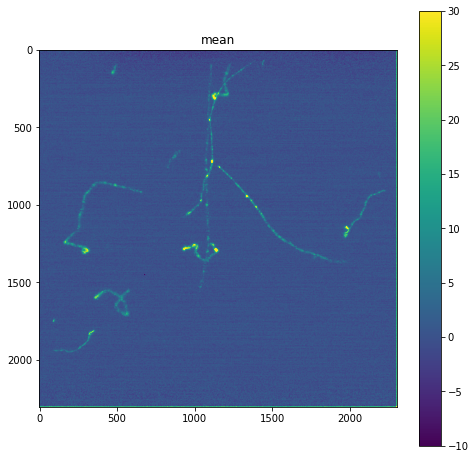

In [2]:
fig, ax = plt.subplots(1, figsize=(8,8))
im = ax.imshow(image-m_image, vmin=-10,vmax=30)
fig.colorbar(im, ax=ax)
ax.set_title("mean")
plt.show()

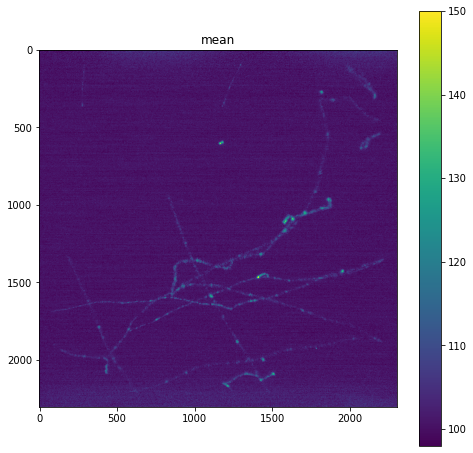

In [337]:
fig, ax = plt.subplots(1, figsize=(8,8))
im = ax.imshow(image, vmin=98,vmax=150)
fig.colorbar(im, ax=ax)
ax.set_title("mean")
plt.show()

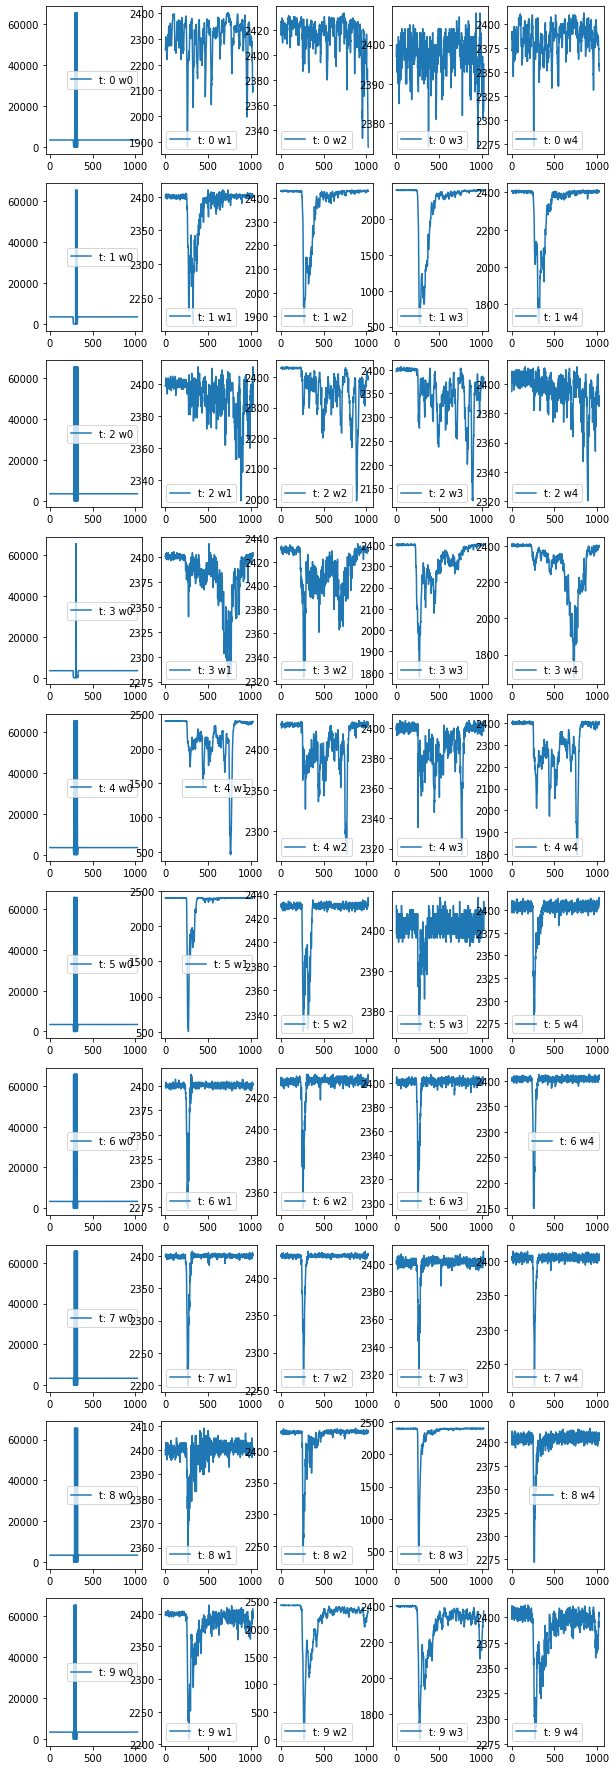

In [413]:
number_of_w_readed = 5
fig, ax = plt.subplots(header[0][0], number_of_w_readed, figsize=(10, header[1][0]))
for t in range(0, header[0][0]):
    offset = t*header[1][0]
    for w in range(0, number_of_w_readed):
        ax[t,w].plot(np.linspace(0, header[2][0], header[2][0]), waveform_f[offset], label="t: {:d} w{:d}".format(t,w))
        ax[t,w].legend()
        #ax[t,w].set_title("trigger: {:d} waveform: {:d}".format(t,w), fontsize='small')
        offset+=1

plt.show()


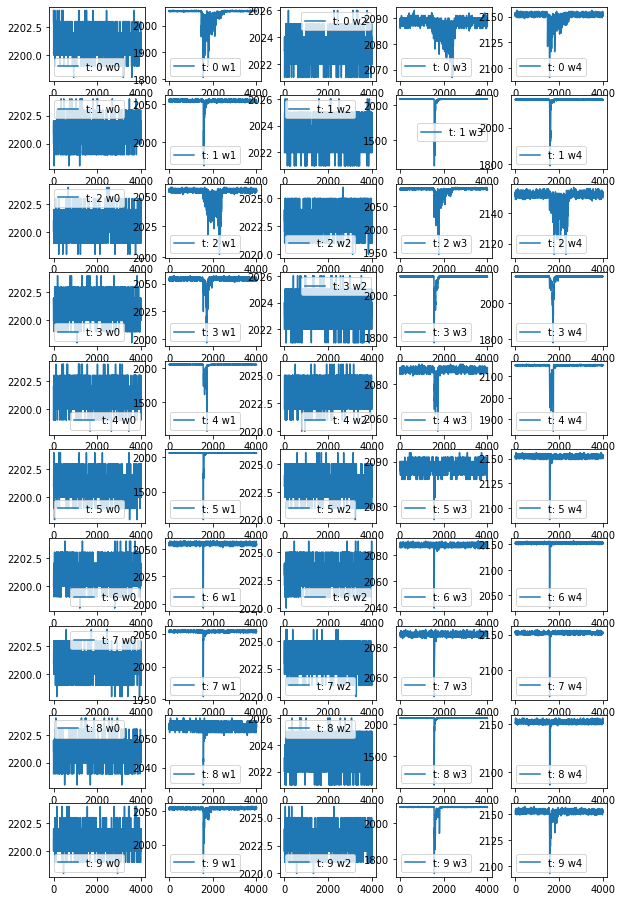

In [414]:
fig, ax = plt.subplots(header[0][1], number_of_w_readed, figsize=(10, 2*header[1][1]))
for t in range(0, header[0][1]):
    offset = t*header[1][1]
    for w in range(0, number_of_w_readed):
        ax[t,w].plot(np.linspace(0, header[2][1], header[2][1]), waveform_s[offset], label="t: {:d} w{:d}".format(t,w))
        ax[t,w].legend()
        #ax[t,w].set_title("trigger: {:d} waveform: {:d}".format(t,w), fontsize='small')
        offset+=1

plt.show()

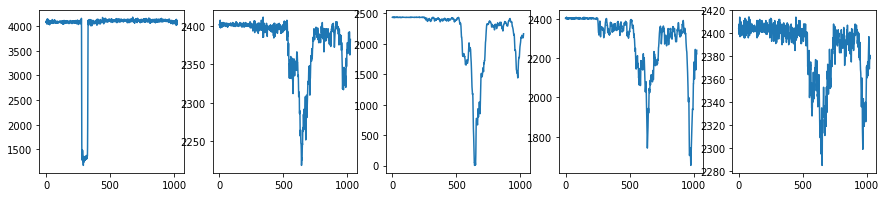

In [7]:
fig, ax = plt.subplots(1, number_of_w_readed, figsize=(15, 3))
trigger = 0
for i, pmt in enumerate(cy.get_pmt_w_by_triggers(waveform, header, number_of_w_readed, trigger)):
    ax[i].plot(np.linspace(0, len(pmt), len(pmt)), pmt)
plt.show()

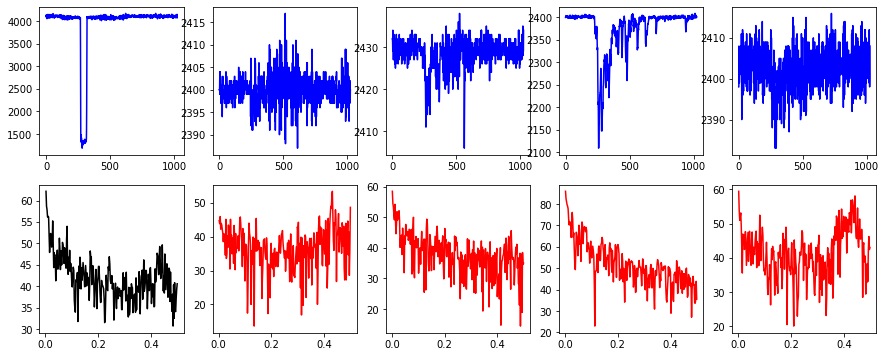

In [56]:

        
fig, ax = plt.subplots(2, number_of_w_readed, figsize=(15, 6))
trigger = 3
t = np.linspace(0, header[2], header[2])
for j, pmt in enumerate(cy.get_pmt_w_by_triggers(waveform, header, number_of_w_readed, trigger)):
    ax[0,j].plot(t, pmt, 'b-')

    if j >=1:
        signalFFT = np.fft.rfft(pmt)
        signalPSD = np.abs(signalFFT) ** 2
        fftFreq = np.fft.fftfreq(len(signalPSD))
        i = fftFreq>0
        A = 10*np.log10(signalPSD[i])
        ax[1,j].plot(fftFreq[i], A, 'r-')
        if j==1:
            pmt_fft_sum = np.zeros(len(A))
        pmt_fft_sum = pmt_fft_sum + A
        
ax[1,0].plot(fftFreq[i], pmt_fft_sum/(number_of_w_readed-1), 'k-')
plt.show()


In [64]:
def get_pmt_w_fft(pmts):
    ffts = []
    for j, pmt in enumerate(pmts):
        signalFFT = np.fft.rfft(pmt)
        signalPSD = np.abs(signalFFT) ** 2
        fftFreq = np.fft.fftfreq(len(signalPSD))
        i = fftFreq>0
        A = 10*np.log10(signalPSD[i])
        ffts.append(A)
        if j==0:
            pmt_fft_sum = np.zeros(len(A))
        pmt_fft_sum = pmt_fft_sum + A
    return fftFreq[i], np.array(ffts), pmt_fft_sum

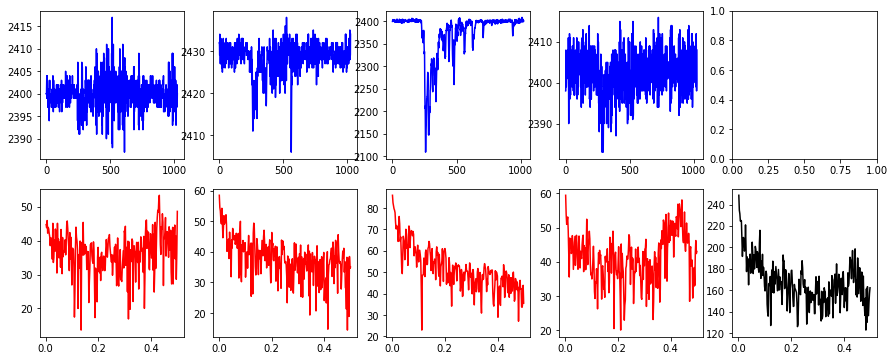

In [66]:

trigger = 3
data = cy.get_pmt_w_by_triggers(waveform, header, number_of_w_readed, trigger)
pmts = data[1:]
t = np.linspace(0, header[2], header[2])
f,ffts, fft_sum = get_pmt_w_fft(pmts)
fig, ax = plt.subplots(2, number_of_w_readed, figsize=(15, 6))
for i, fft in enumerate(ffts):
    ax[0,i].plot(t, pmts[i], 'b-')
    ax[1,i].plot(f,fft, 'r-')
ax[1,i+1].plot(f,fft_sum, 'k-')
plt.show()

In [83]:
30%10

0

In [90]:

mfile = cy.open_mid(run=6061, path='/s3/cygno-data/', cloud=False, tag='LNGS', verbose=False)
number_of_w_readed = 5
df = pd.DataFrame(columns=['ev', 'trigger', 'fft_sum'])
for event in mfile:
    if event.header.is_midas_internal_event():
        print("Saw a special event")
        continue

    bank_names = ", ".join(b.name for b in event.banks.values())
    if event.header.serial_number%50==0: 
        print("Event # %s of type ID %s contains banks %s" % (event.header.serial_number, event.header.event_id, bank_names))
        print("Received event with timestamp %s containing banks %s" % (event.header.timestamp, bank_names))
        print("%s, banks %s" % (datetime.utcfromtimestamp(event.header.timestamp).strftime('%Y-%m-%d %H:%M:%S'), bank_names))

    for bank_name, bank in event.banks.items():
        if bank_name=='DGH0': # PMTs wavform 
            header = cy.daq_dgz2header(bank)
            waveform = cy.daq_dgz2array(event.banks['DIG0'], header)
            for trigger in range(0, header[0]):
                all_w = cy.get_pmt_w_by_triggers(waveform, header, number_of_w_readed, trigger)
                pmts = all_w[1:]
                f,ffts, fft_sum = get_pmt_w_fft(pmts)
                df = df.append({'ev':event.header.serial_number, 'trigger':trigger, 'fft_sum':fft_sum}, ignore_index=True)
                    
#         if bank_name=='CAM0': # CAM image
#             image, _, _ = cy.daq_cam2array(bank) # matrice delle imagine

#         if bank_name=='INPT': # SLOW channels array
#             slow = cy.daq_slow2array(bank)



Saw a special event
Event # 0 of type ID 3 contains banks DMND, MSRD, CRNT, STAT, TPTR
Received event with timestamp 1670048651 containing banks DMND, MSRD, CRNT, STAT, TPTR
2022-12-03 06:24:11, banks DMND, MSRD, CRNT, STAT, TPTR
Event # 0 of type ID 4 contains banks DMND, MSRD, CRNT, STAT, TPTR
Received event with timestamp 1670048651 containing banks DMND, MSRD, CRNT, STAT, TPTR
2022-12-03 06:24:11, banks DMND, MSRD, CRNT, STAT, TPTR
Event # 0 of type ID 6 contains banks DMND, MSRD
Received event with timestamp 1670048651 containing banks DMND, MSRD
2022-12-03 06:24:11, banks DMND, MSRD
Event # 0 of type ID 1 contains banks DIG0, DGH0, CAM0
Received event with timestamp 1670048652 containing banks DIG0, DGH0, CAM0
2022-12-03 06:24:12, banks DIG0, DGH0, CAM0
Event # 0 of type ID 7 contains banks TCAM
Received event with timestamp 1670048653 containing banks TCAM
2022-12-03 06:24:13, banks TCAM
Event # 0 of type ID 5 contains banks INPT
Received event with timestamp 1670048658 containi

In [91]:
df

ev trigger                                            fft_sum
0       0       0  [335.95725752087395, 325.4303725978946, 311.62...
1       0       1  [260.62393922482676, 227.644070860079, 231.638...
2       0       2  [324.8558157959182, 321.954718930515, 321.6623...
3       0       3  [288.3481408107516, 287.58233652834707, 265.50...
4       0       4  [193.44644227449626, 161.12922327016722, 153.1...
...   ...     ...                                                ...
6237  401       9  [220.07810126311495, 191.44968887539181, 188.5...
6238  401      10  [332.2150596425926, 284.9241467205257, 250.987...
6239  401      11  [302.2401578467552, 268.25090795410966, 271.65...
6240  401      12  [272.3302148104486, 226.13166330768888, 177.49...
6241  401      13  [314.36225180783276, 306.2592531675651, 296.01...

[6242 rows x 3 columns]

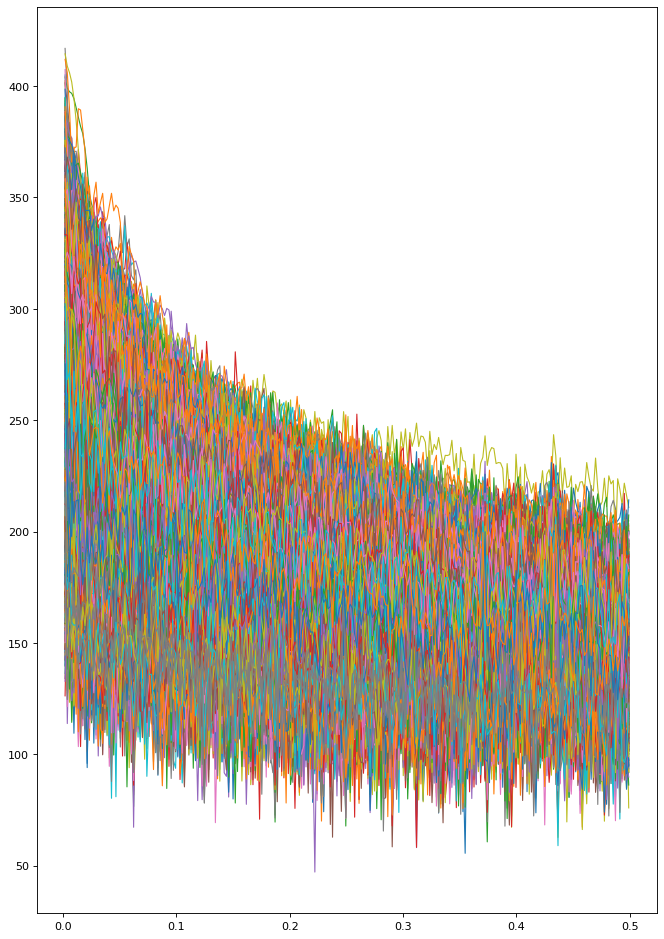

In [97]:
plt.figure(figsize=(10, 15), dpi=80)
for i, ffts in enumerate(df.fft_sum):
    plt.plot(f, ffts, linewidth='1')
plt.show()

In [110]:
def obj_array_to_type(arr, typ):
    """
    Convert an object array of same-sized arrays to a normal 3D array
    with dtype=typ. This is a workaround as numpy doesn't realize that
    the object arrays are numpy arrays of the same legth, so just using
    array.astype(typ) fails. Technically works if the items are numbers
    and not arrays, but then `arr.astype(typ)` should be used.
    """
    full_shape = (*arr.shape, *np.shape(arr.flat[0]))
    return np.vstack(arr.flatten()).astype(typ).reshape(full_shape)
obj_array_to_type(df.fft_sum.values, float)

array([[335.95725752, 325.4303726 , 311.62990814, ..., 166.58711886,
        163.84280271, 178.92562017],
       [260.62393922, 227.64407086, 231.63872557, ..., 160.39567486,
        139.65517288, 157.91256696],
       [324.8558158 , 321.95471893, 321.66234956, ..., 157.71280155,
        158.04215112, 157.59242969],
       ...,
       [302.24015785, 268.25090795, 271.65577478, ..., 171.07898775,
        185.40216291, 161.31453329],
       [272.33021481, 226.13166331, 177.49763559, ..., 163.95916613,
        142.77331681, 151.87450116],
       [314.36225181, 306.25925317, 296.01138564, ..., 157.67160784,
        164.77345075, 153.46136226]])

In [148]:
from sklearn.cluster import KMeans


kmeans = KMeans(n_clusters=6, init='k-means++', max_iter=300, n_init=10, random_state=0)

pred_y = kmeans.fit_predict(obj_array_to_type(df.fft_sum.values, float))

df['cw'] = kmeans.labels_

In [119]:
df

ev trigger                                            fft_sum  cw
0       0       0  [335.95725752087395, 325.4303725978946, 311.62...   0
1       0       1  [260.62393922482676, 227.644070860079, 231.638...   0
2       0       2  [324.8558157959182, 321.954718930515, 321.6623...   2
3       0       3  [288.3481408107516, 287.58233652834707, 265.50...   0
4       0       4  [193.44644227449626, 161.12922327016722, 153.1...   1
...   ...     ...                                                ...  ..
6237  401       9  [220.07810126311495, 191.44968887539181, 188.5...   1
6238  401      10  [332.2150596425926, 284.9241467205257, 250.987...   2
6239  401      11  [302.2401578467552, 268.25090795410966, 271.65...   0
6240  401      12  [272.3302148104486, 226.13166330768888, 177.49...   0
6241  401      13  [314.36225180783276, 306.2592531675651, 296.01...   0

[6242 rows x 4 columns]

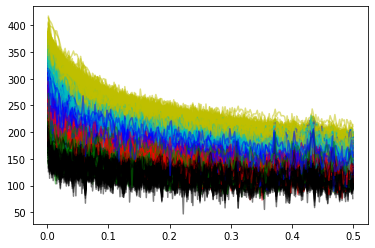

In [149]:
for i in range(len(pred_y)):
    fft_p = df.fft_sum.values[i]
    if pred_y[i] == 0:
        plt.plot(f,fft_p, 'b', alpha=0.5)
    if pred_y[i] == 1:
        plt.plot(f,fft_p, 'g', alpha=0.5)
    if pred_y[i] == 2:
        plt.plot(f,fft_p, 'r', alpha=0.5)
    if pred_y[i] == 3:
        plt.plot(f,fft_p, 'k', alpha=0.5)
    if pred_y[i] == 4:
        plt.plot(f,fft_p, 'y', alpha=0.5)
    if pred_y[i] == 5:
        plt.plot(f,fft_p, 'c', alpha=0.5)

In [122]:
# plt.hist(df.fft_sum[df.cw==0], bins=100, color='k', alpha=0.5)
# plt.hist(df.fft_sum[df.cw==1], bins=100, color='g', alpha=0.5)
# plt.hist(df.fft_sum[df.cw==2], bins=100, color='r', alpha=0.5)
# #ax[1].set_yscale('Log')
# plt.show()

In [144]:
2 in df[(df.cw==2) & (df.ev==2)].trigger.values

True

Saw a special event


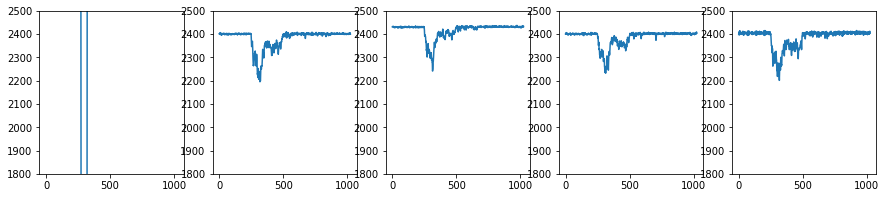

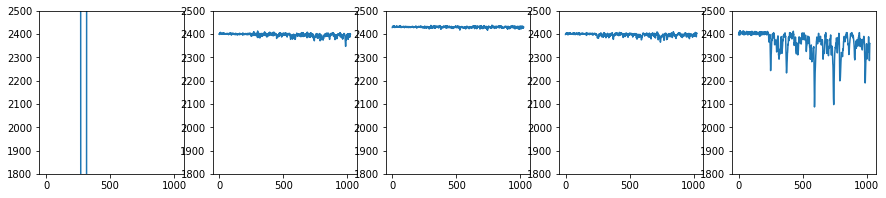

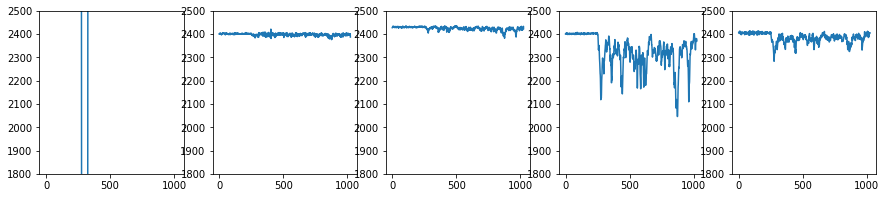

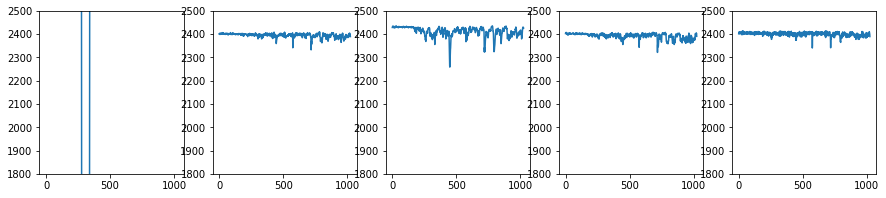

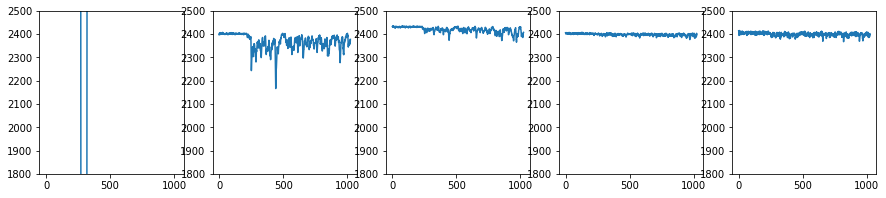

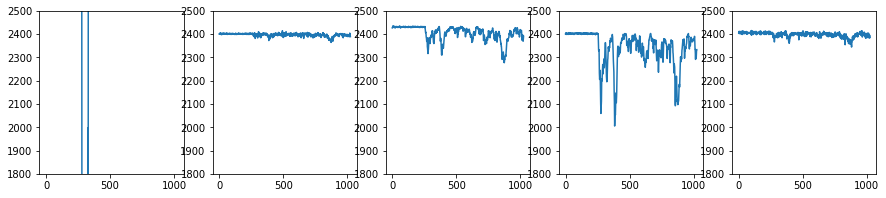

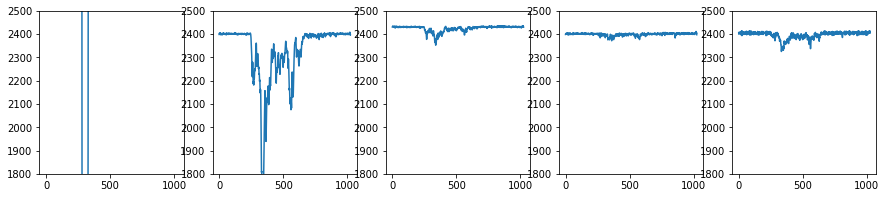

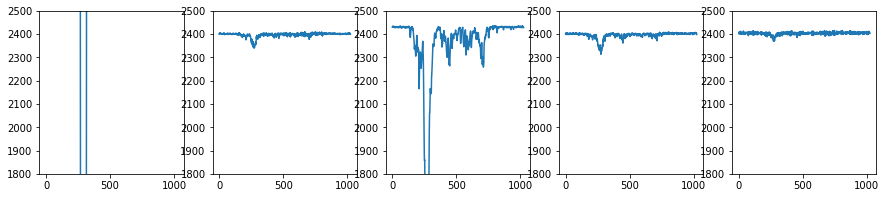

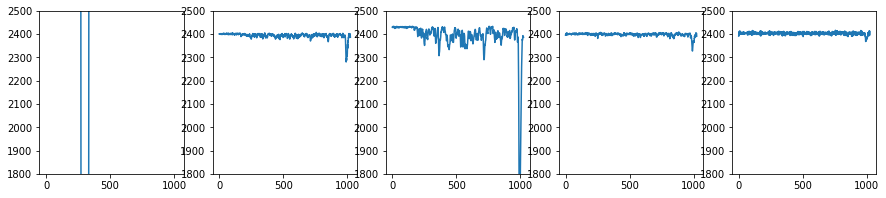

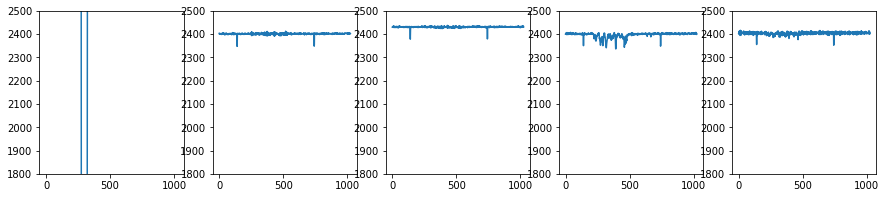

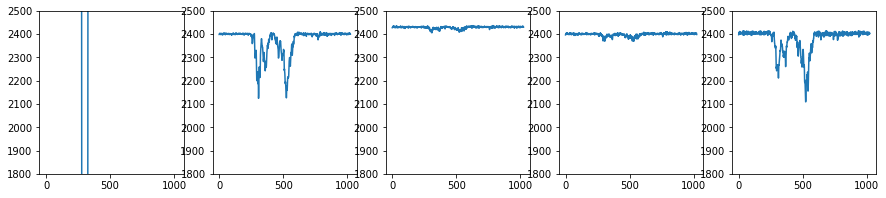

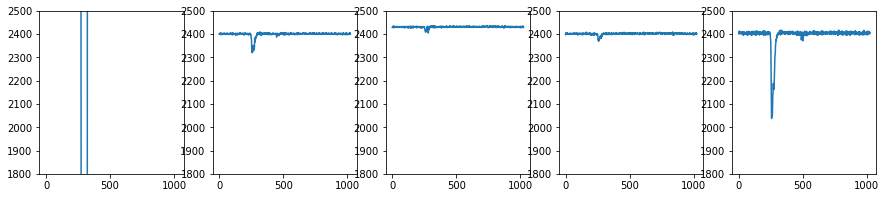

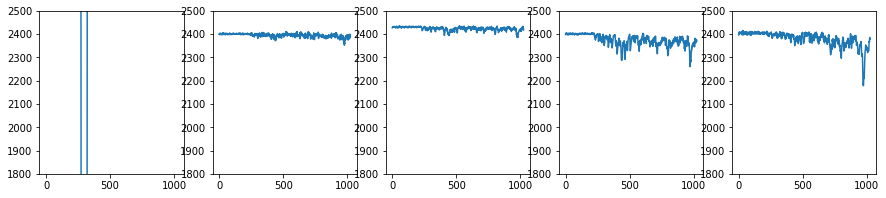

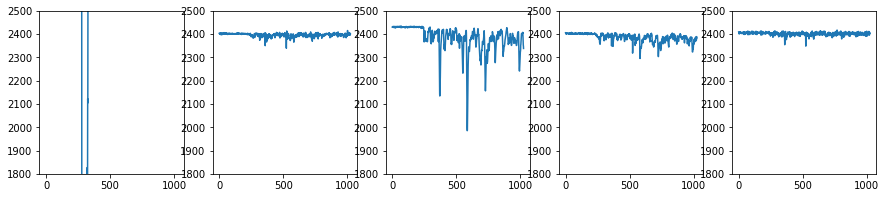

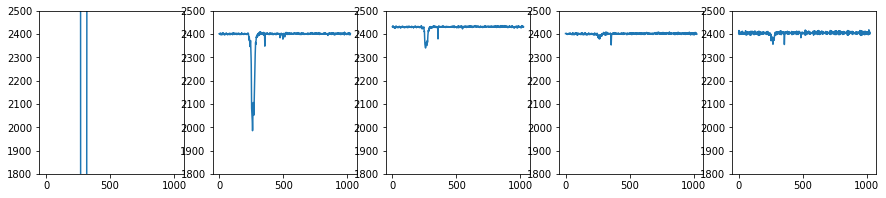

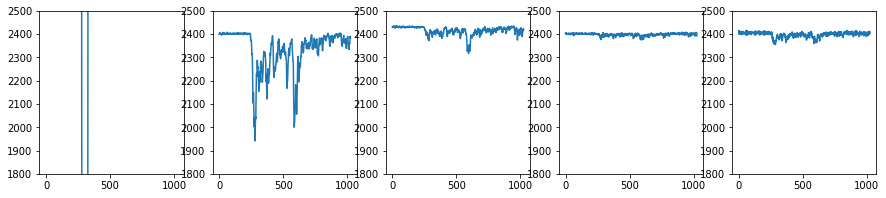

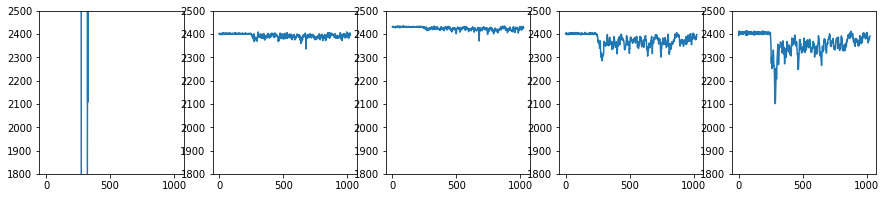

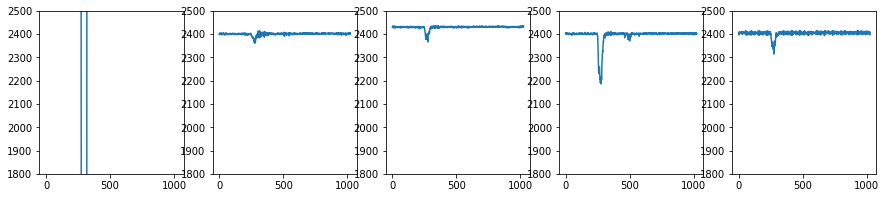

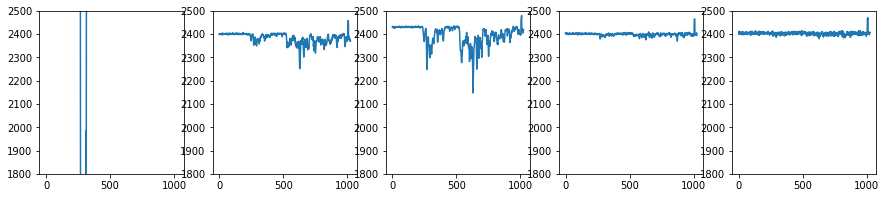

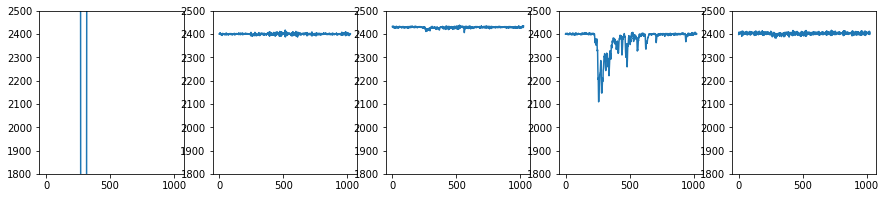

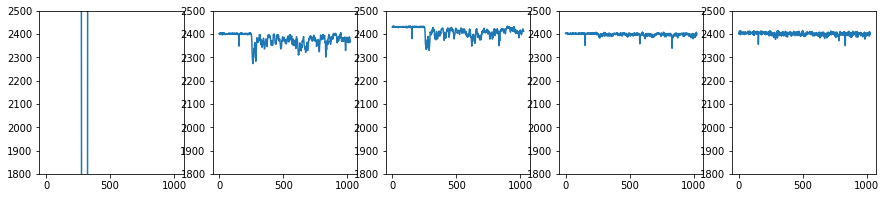

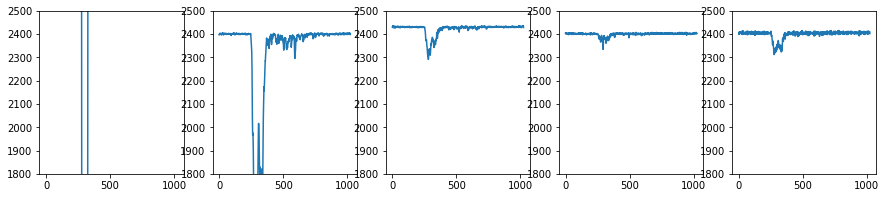

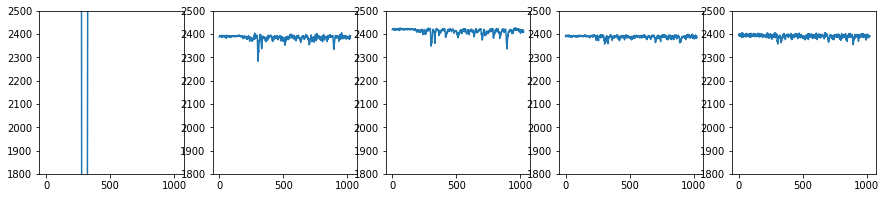

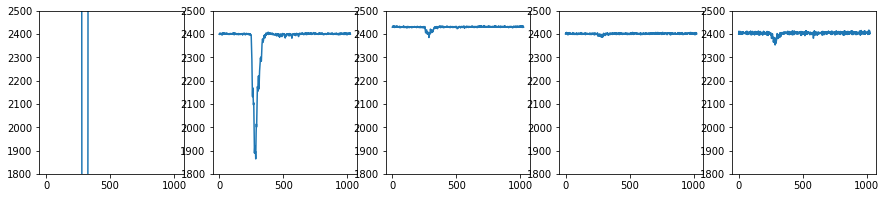

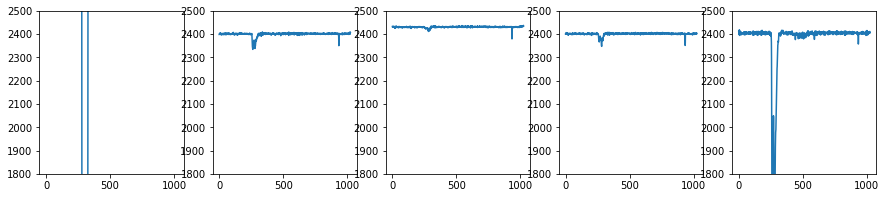

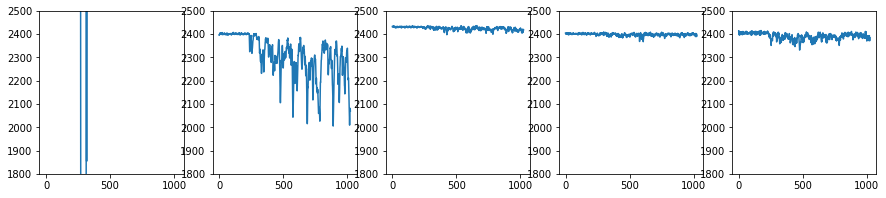

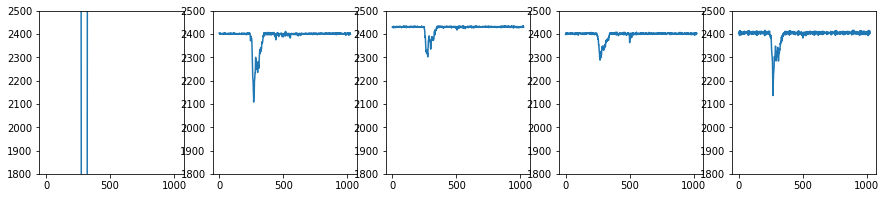

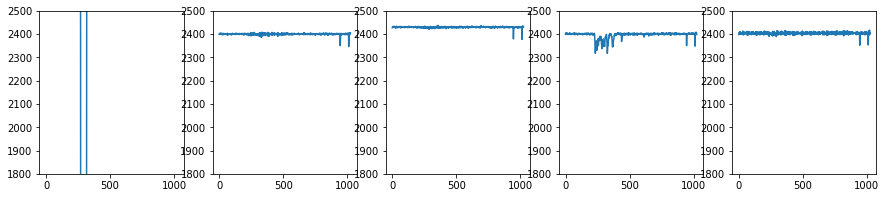

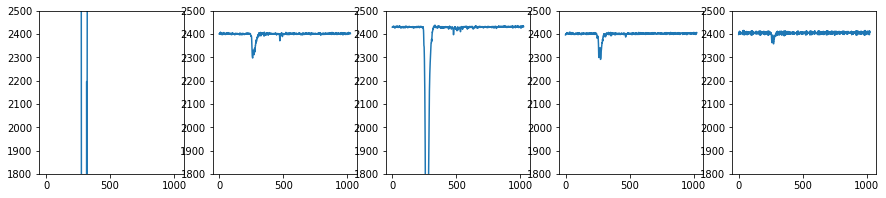

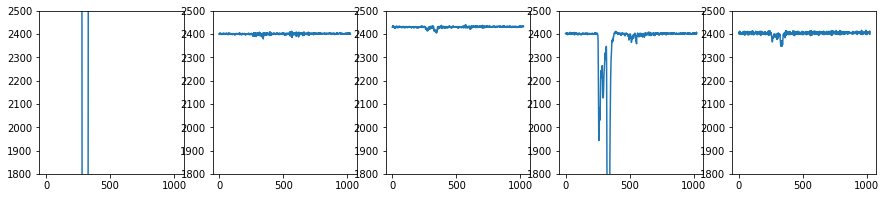

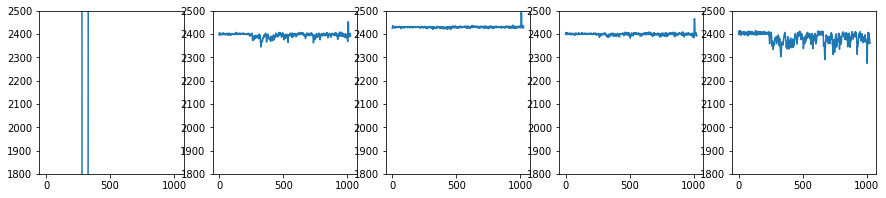

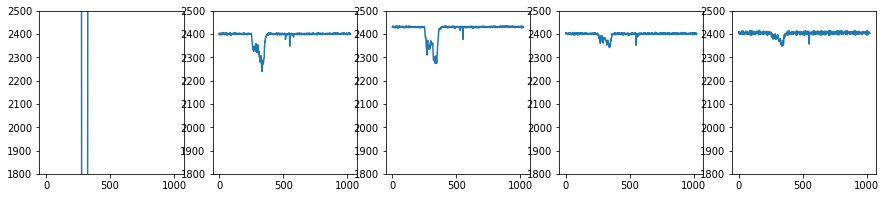

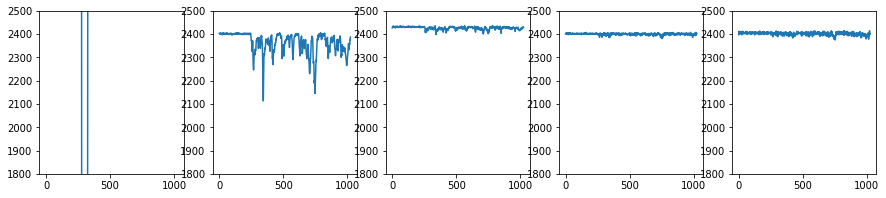

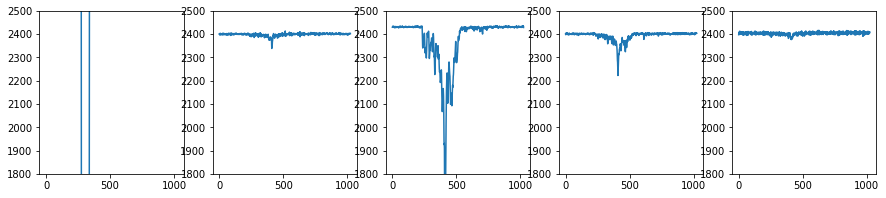

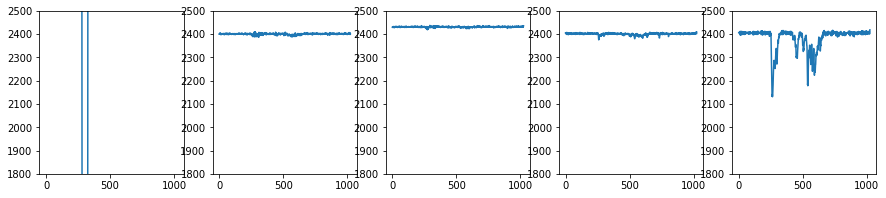

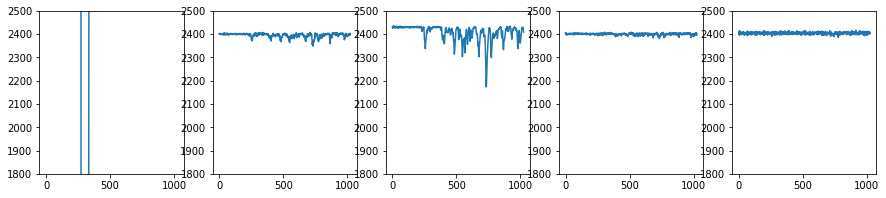

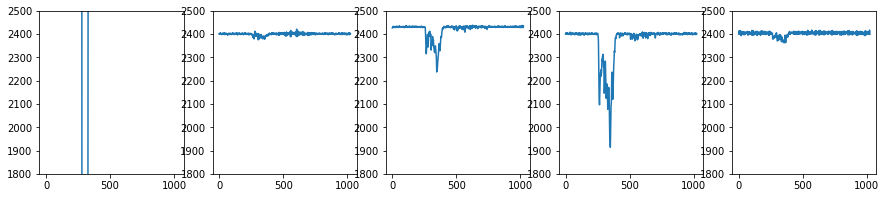

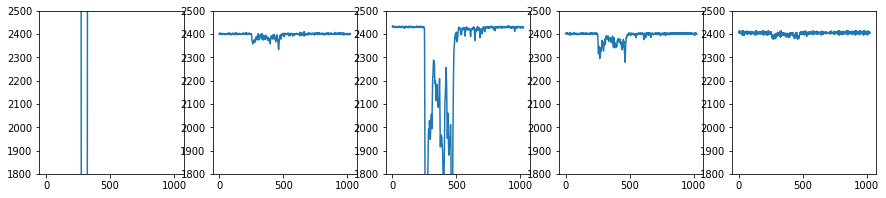

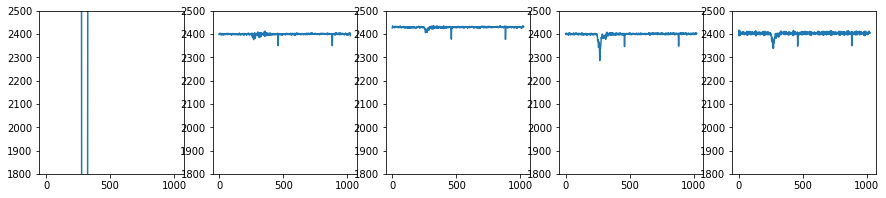

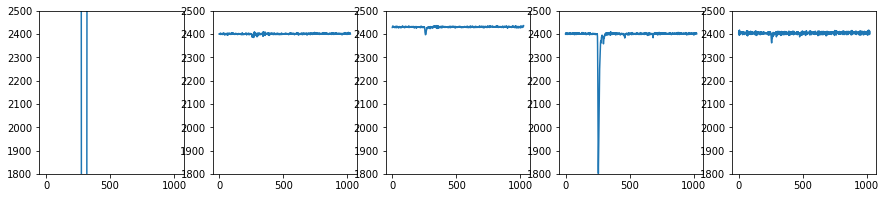

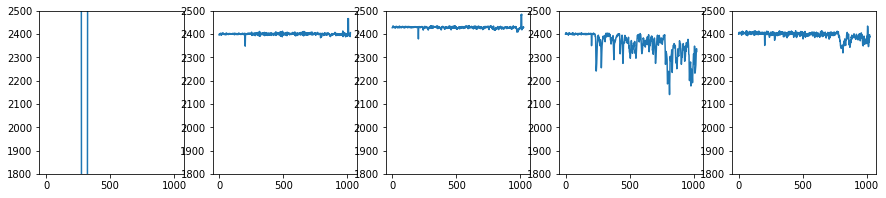

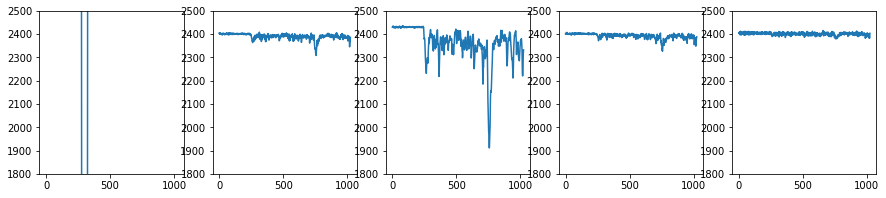

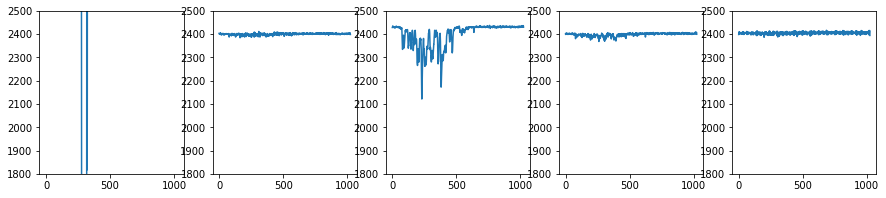

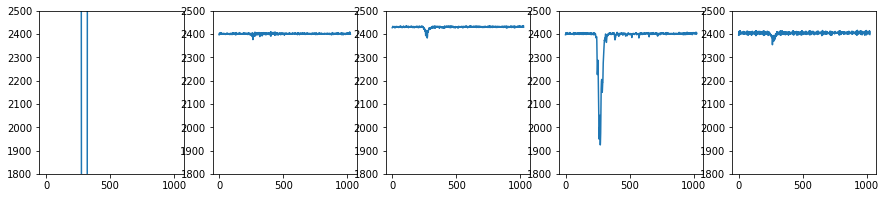

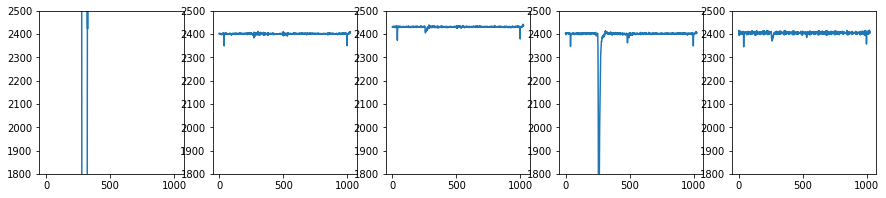

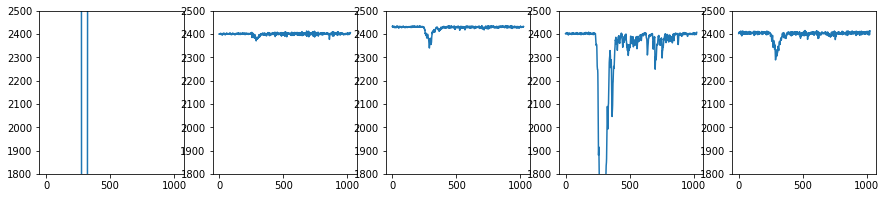

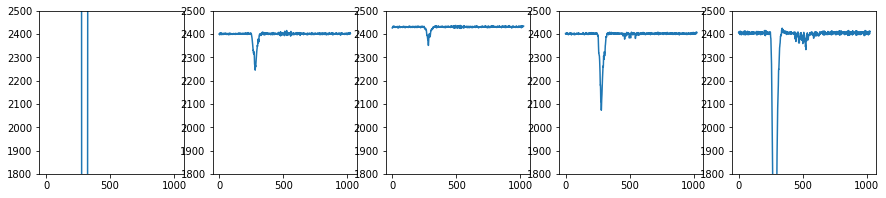

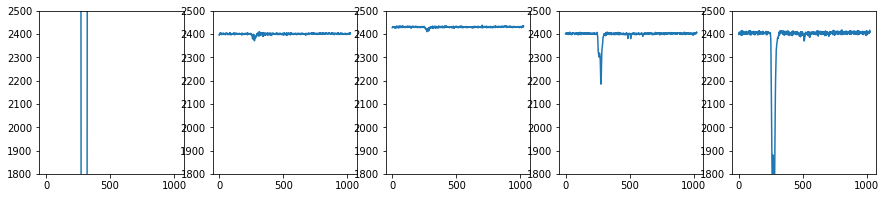

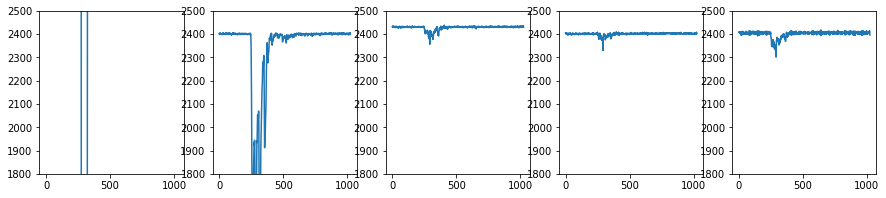

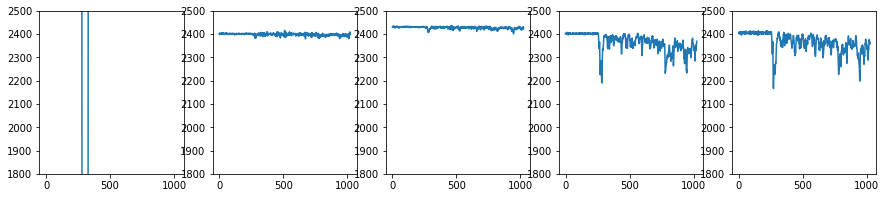

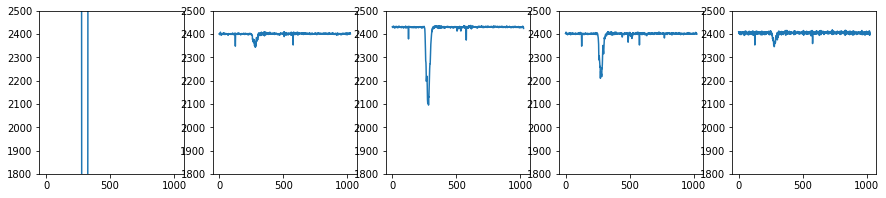

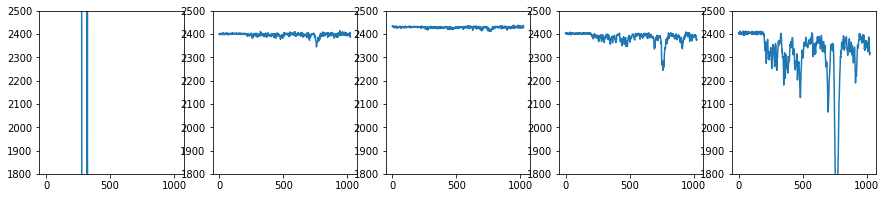

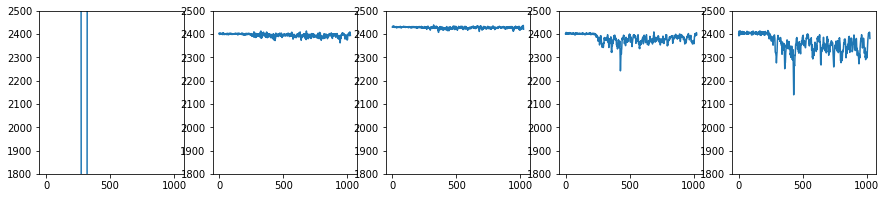

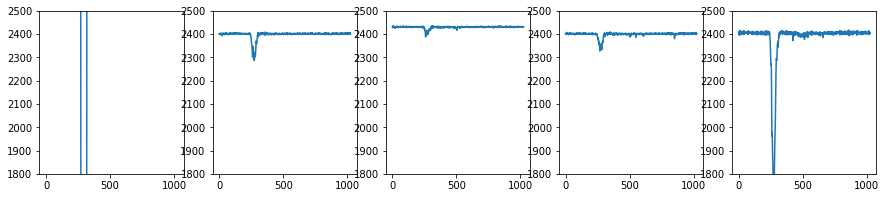

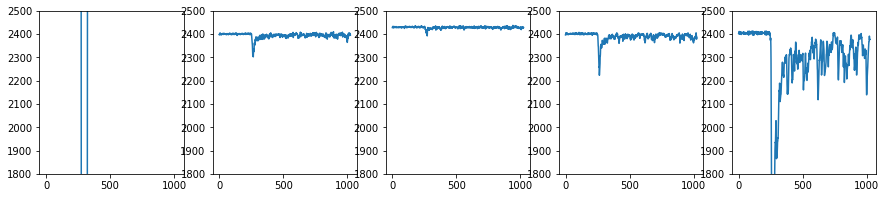

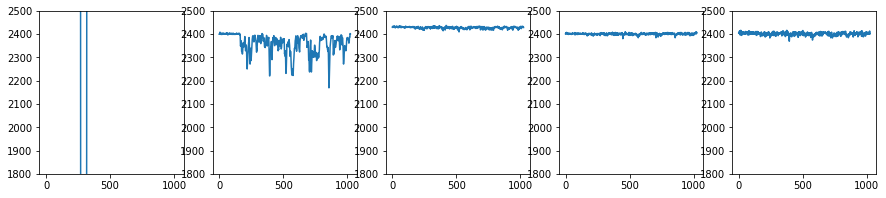

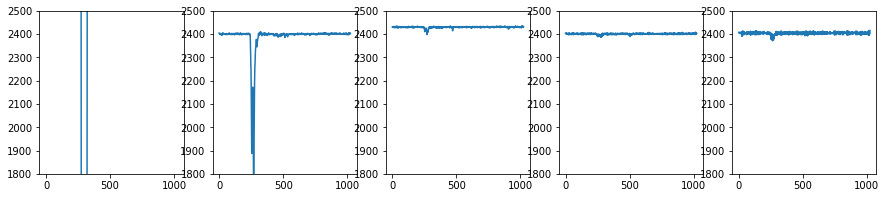

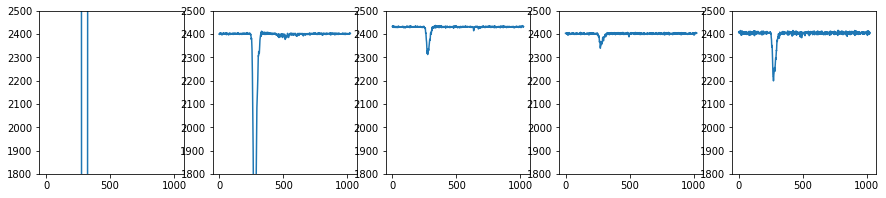

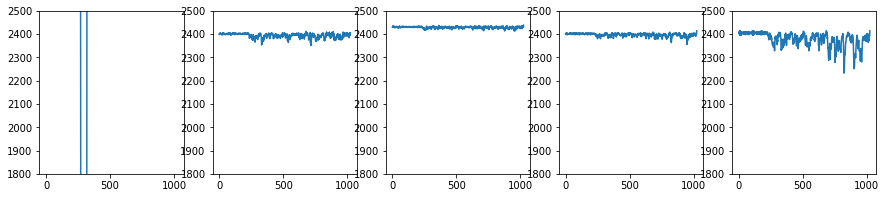

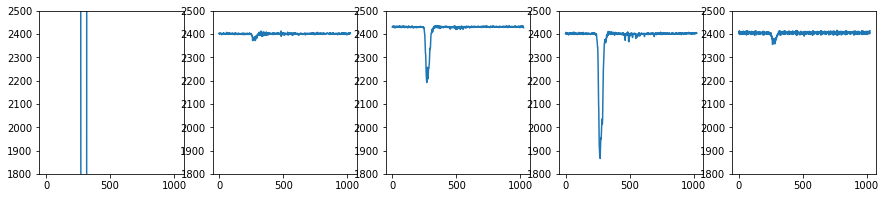

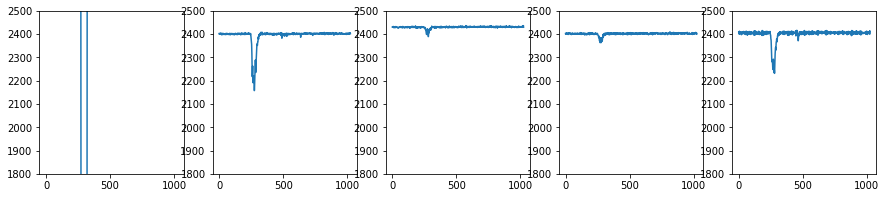

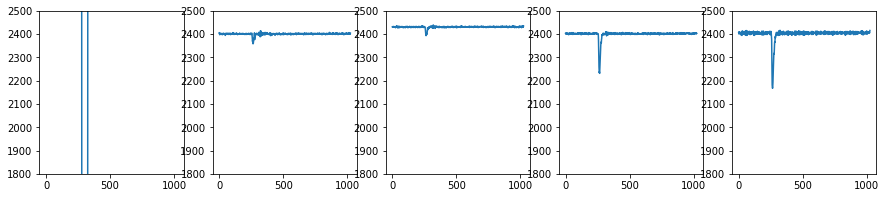

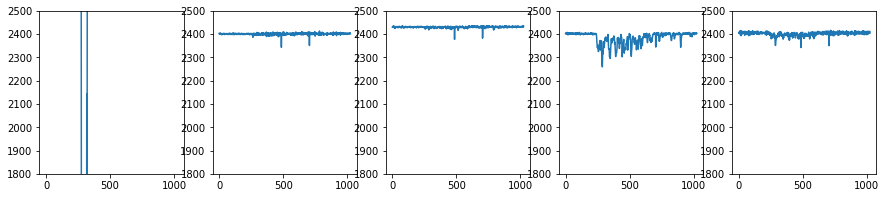

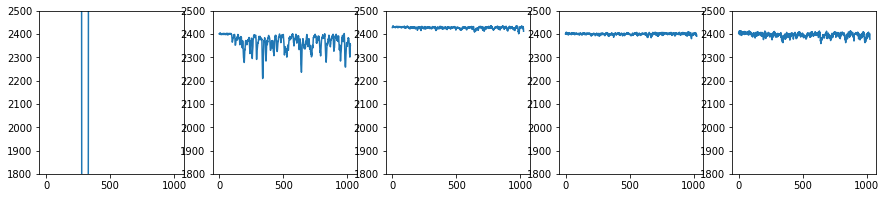

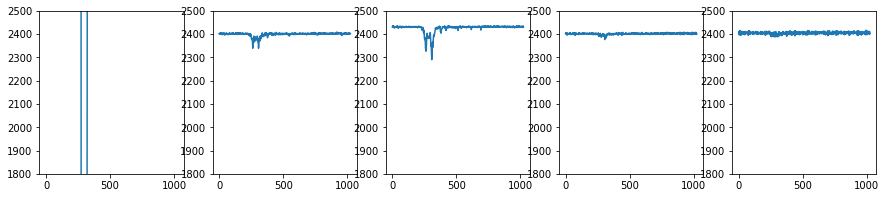

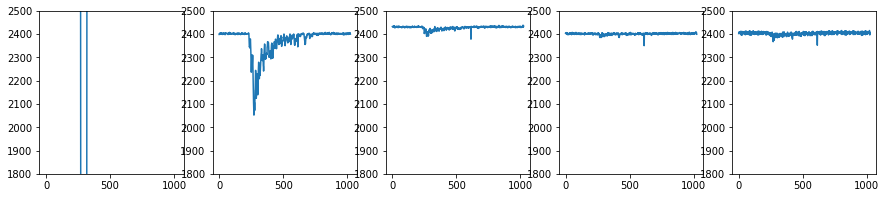

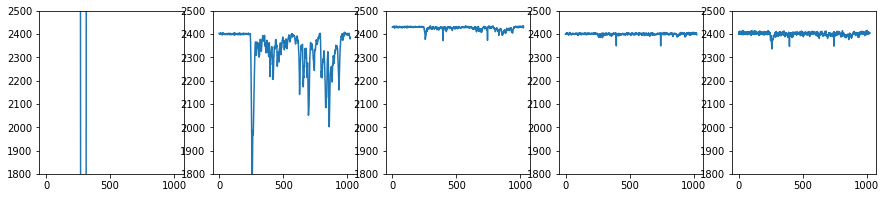

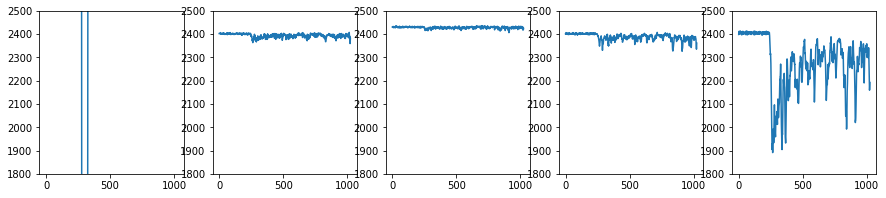

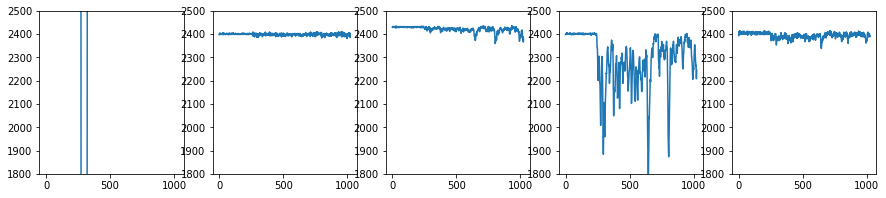

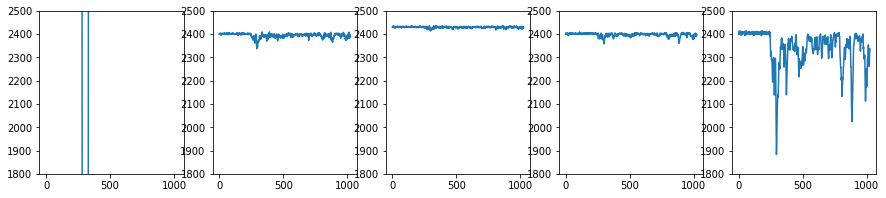

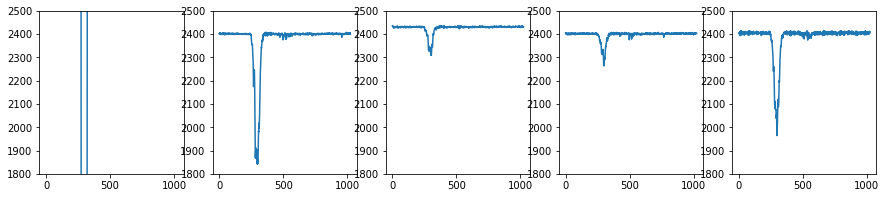

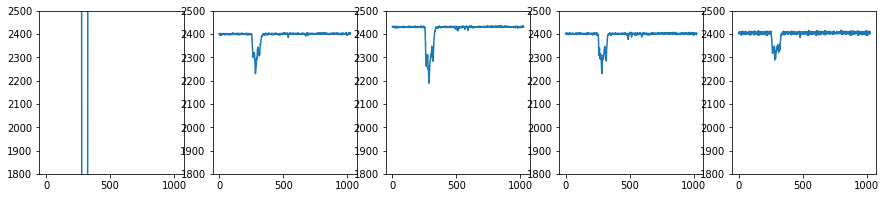

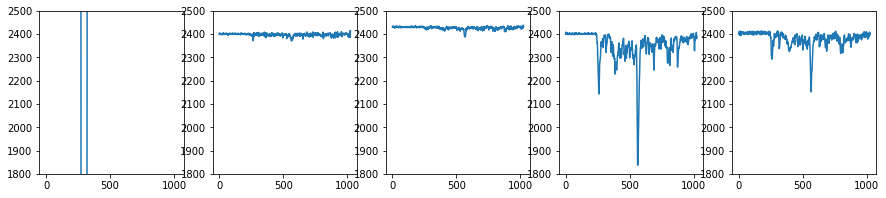

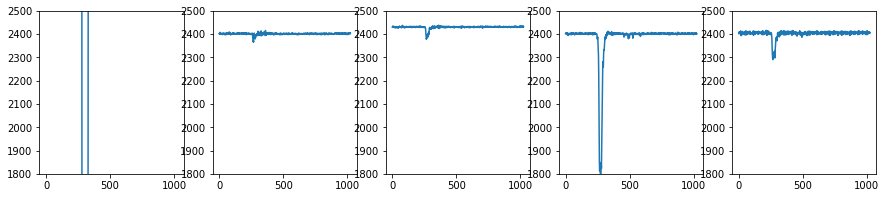

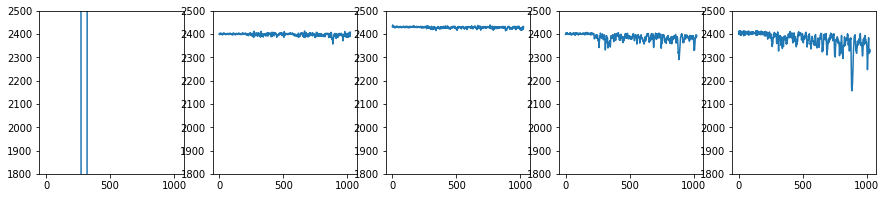

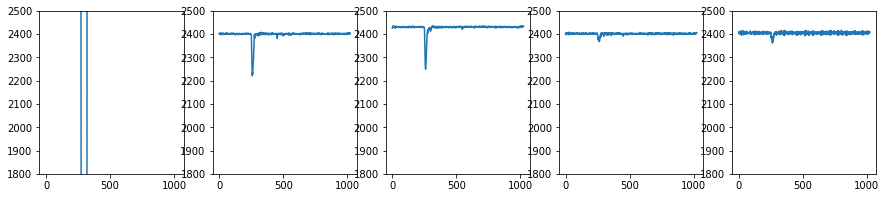

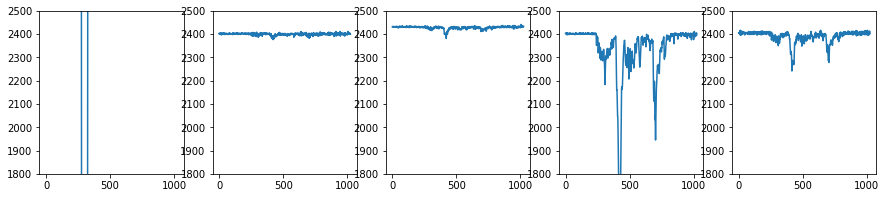

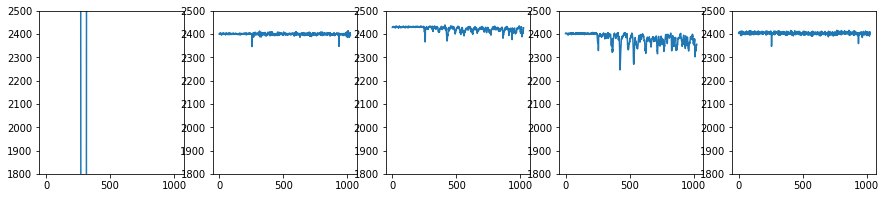

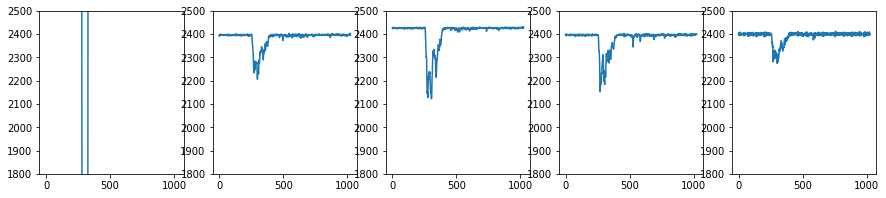

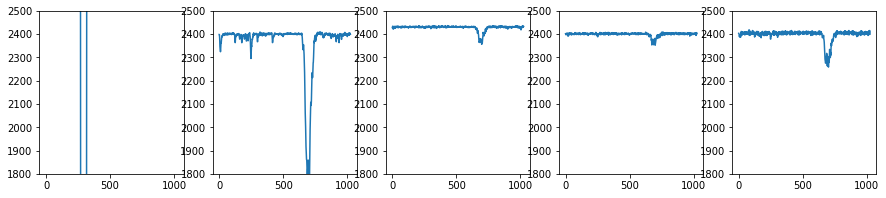

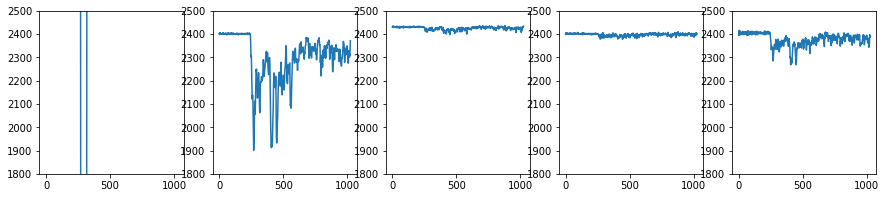

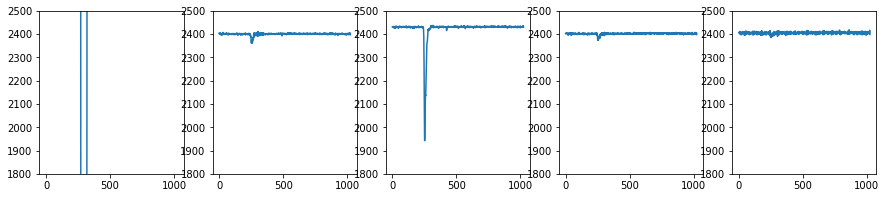

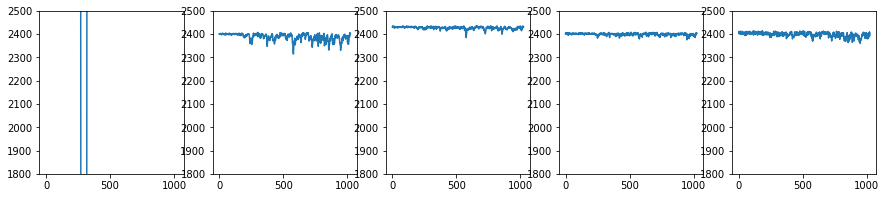

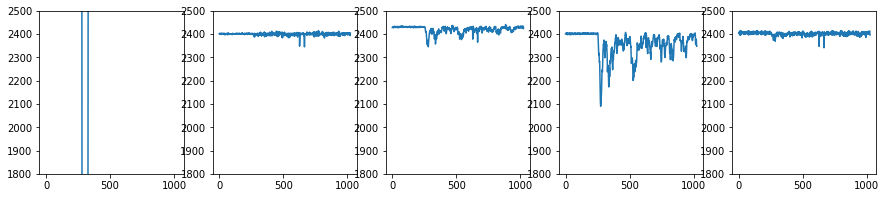

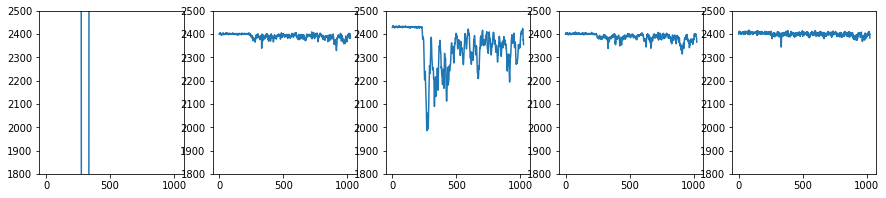

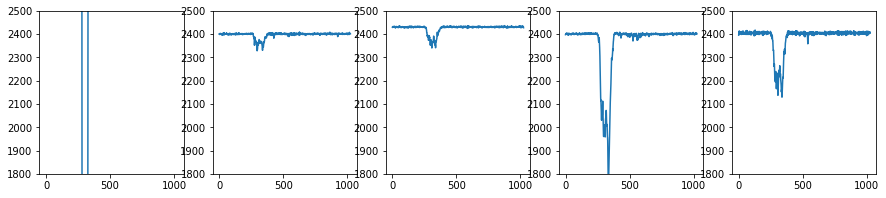

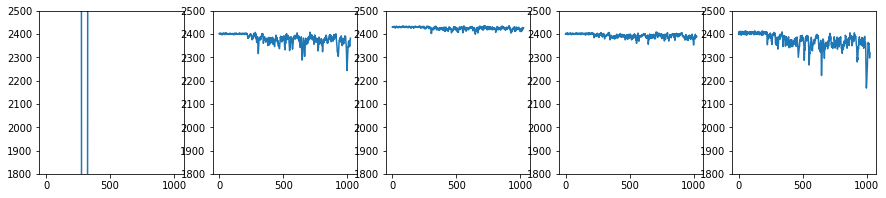

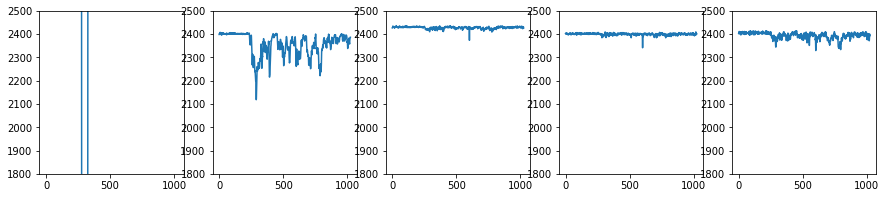

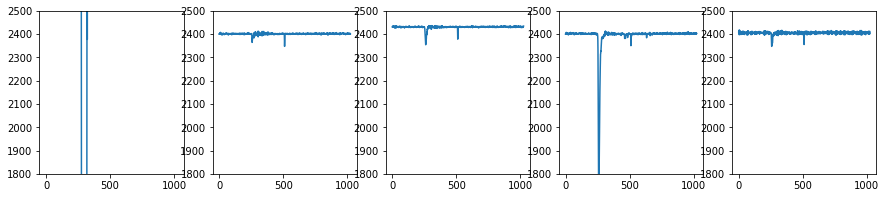

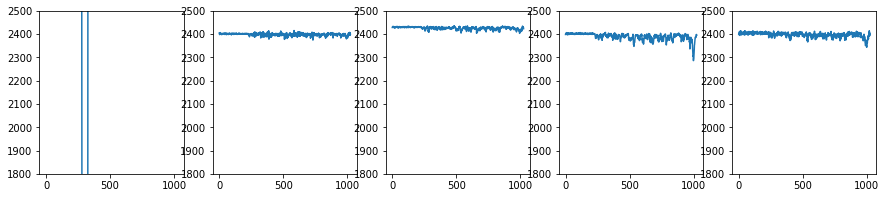

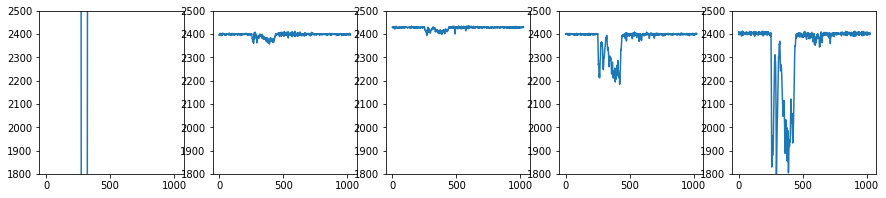

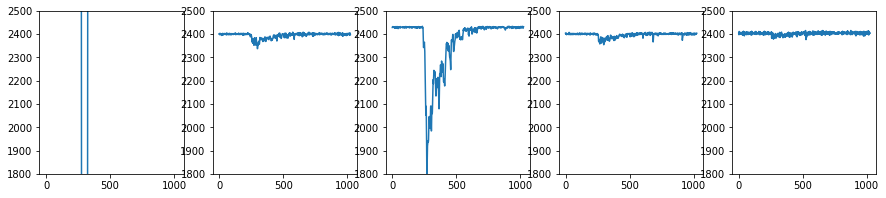

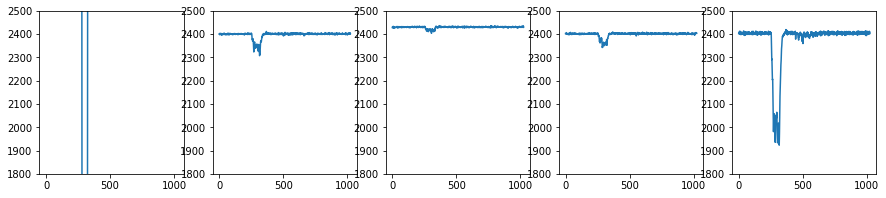

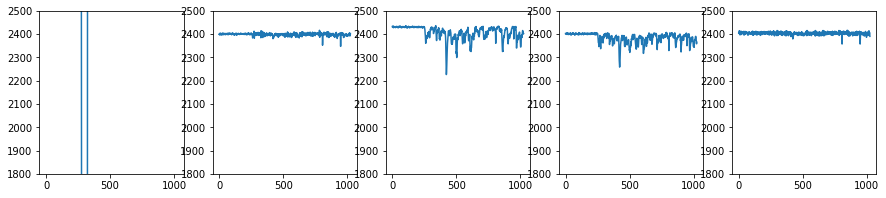

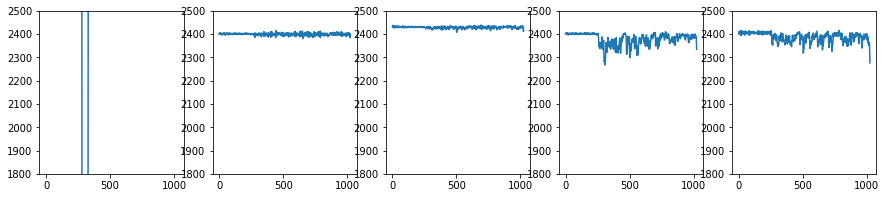

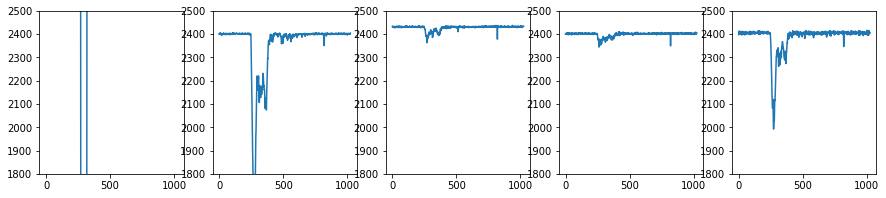

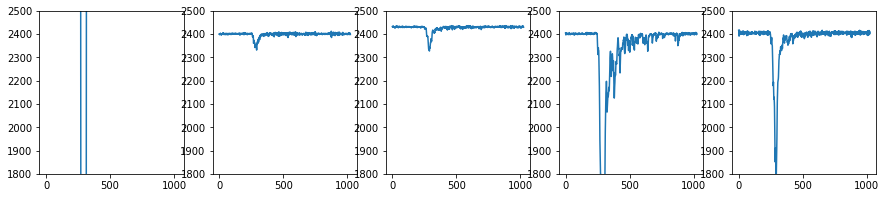

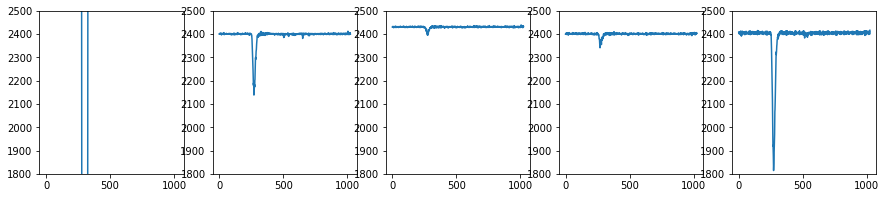

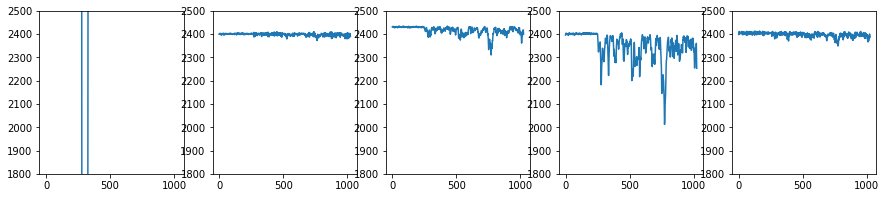

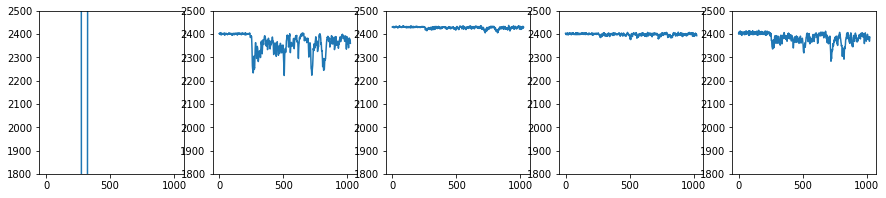

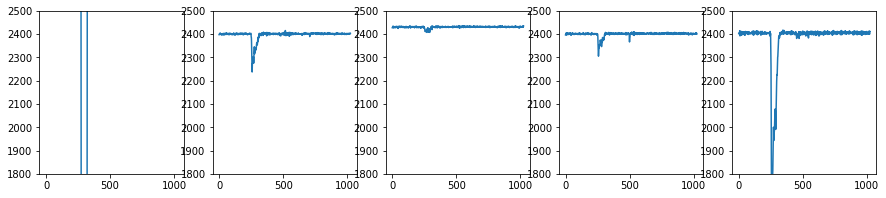

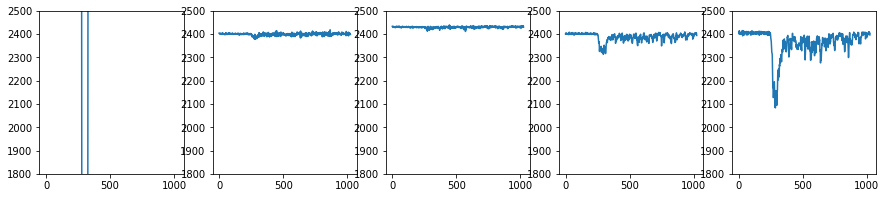

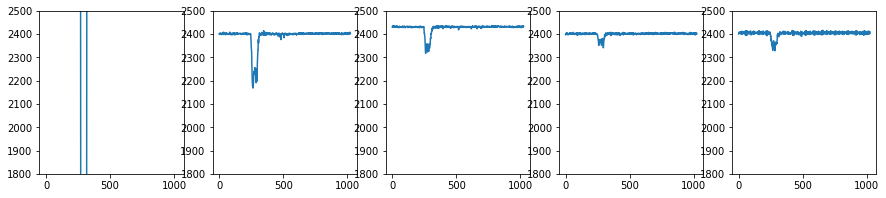

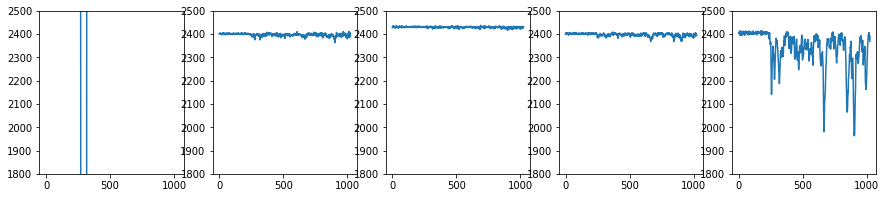

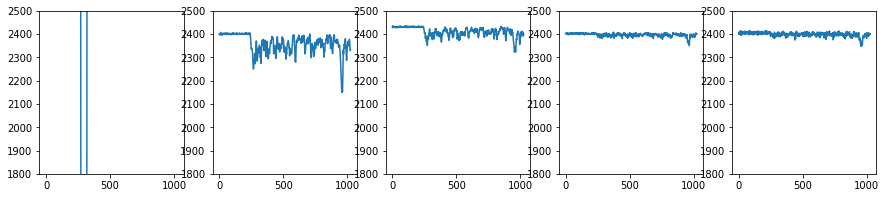

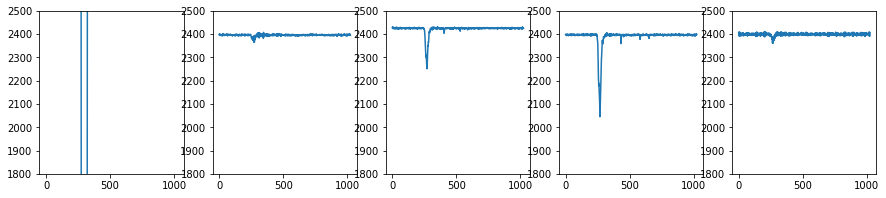

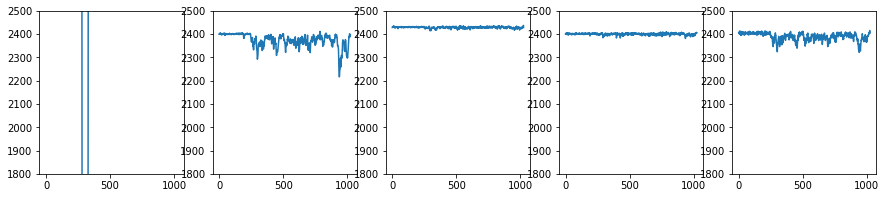

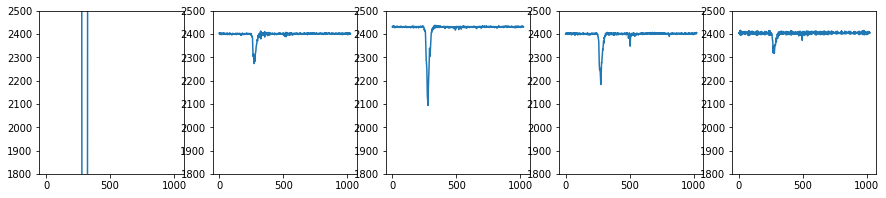

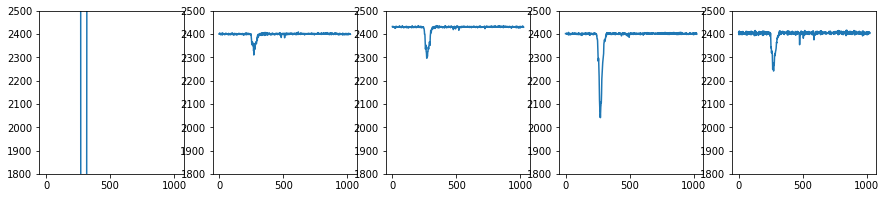

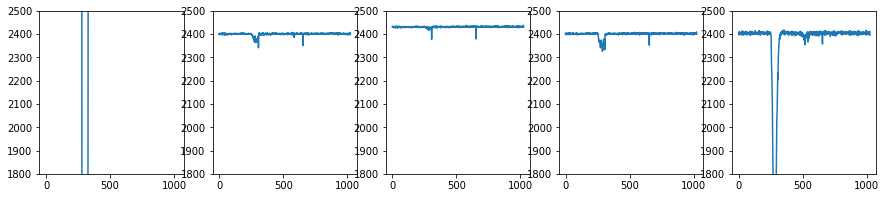

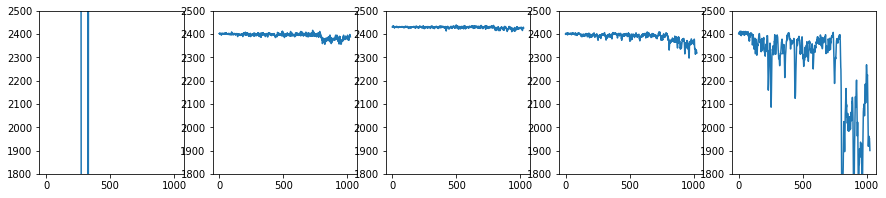

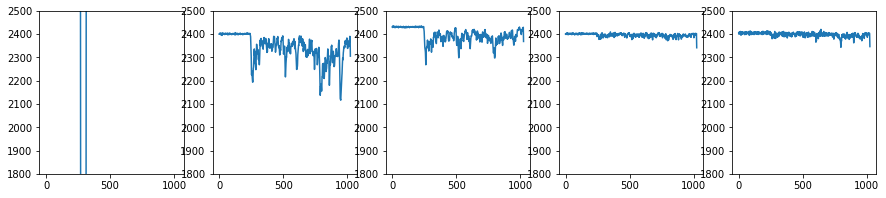

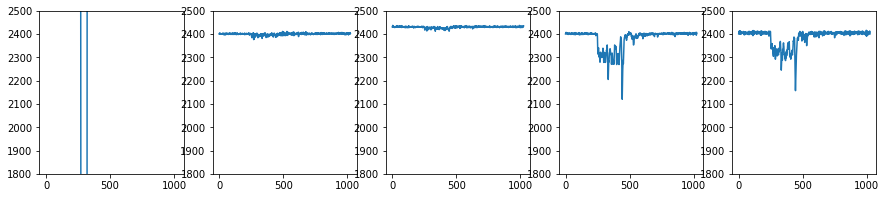

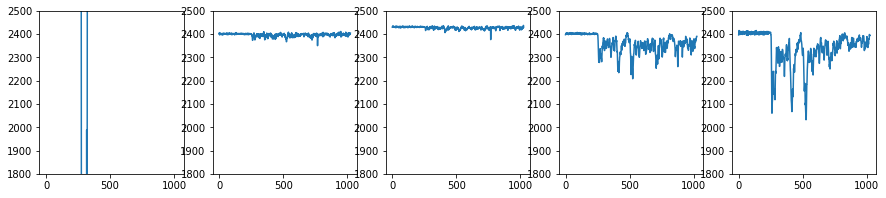

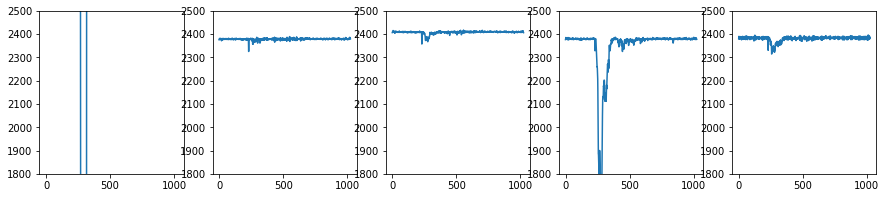

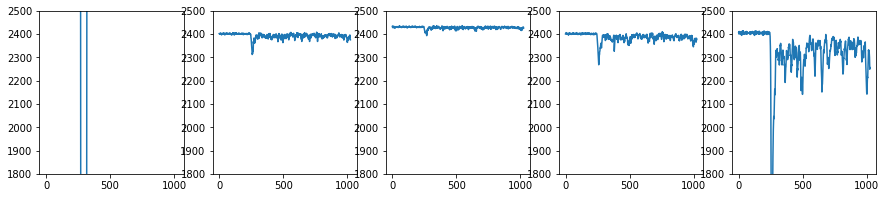

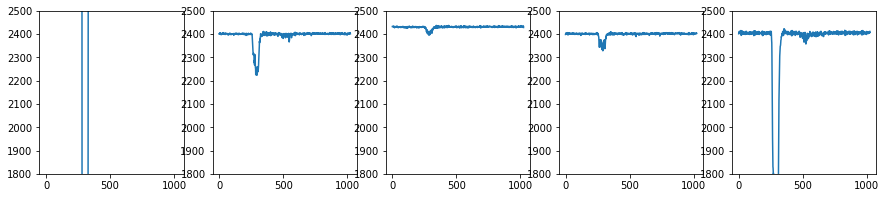

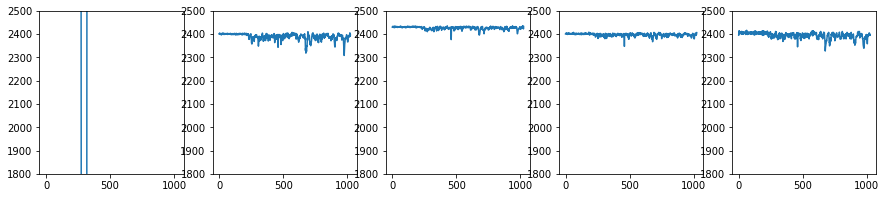

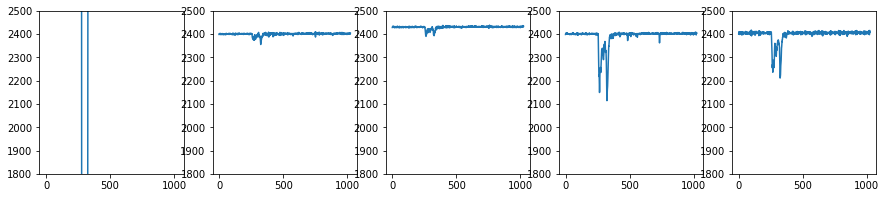

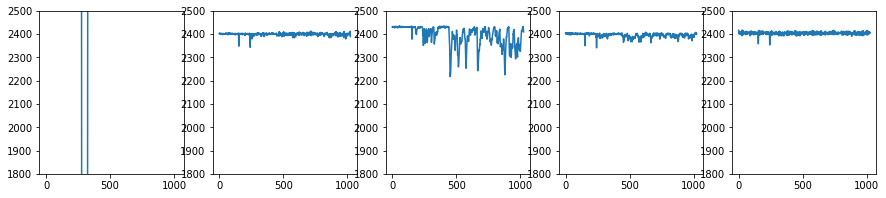

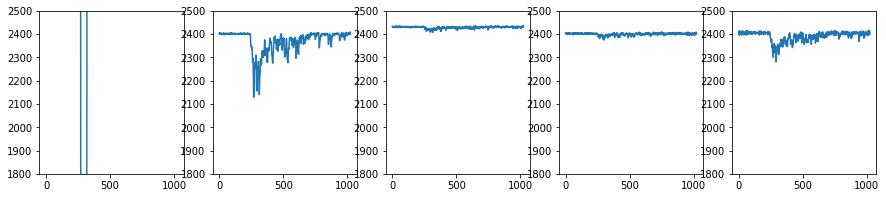

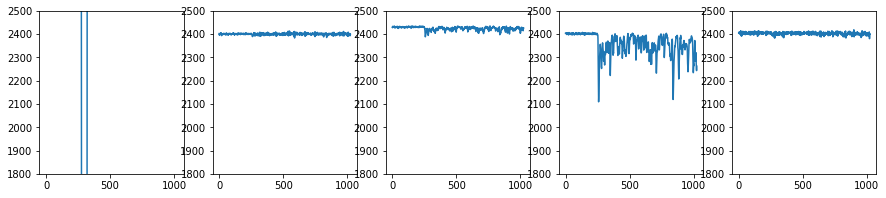

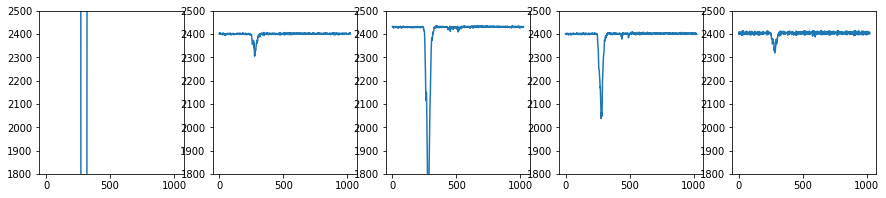

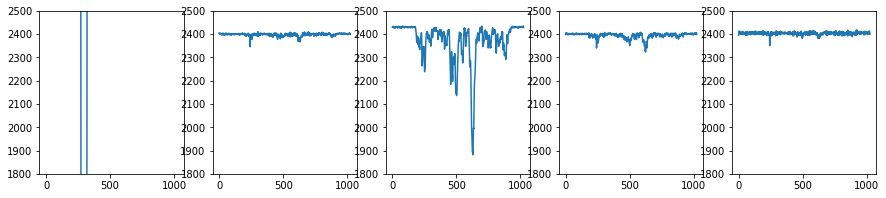

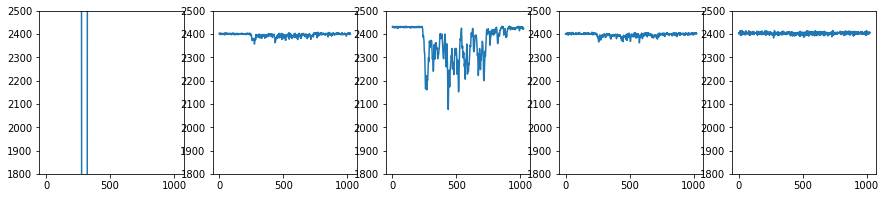

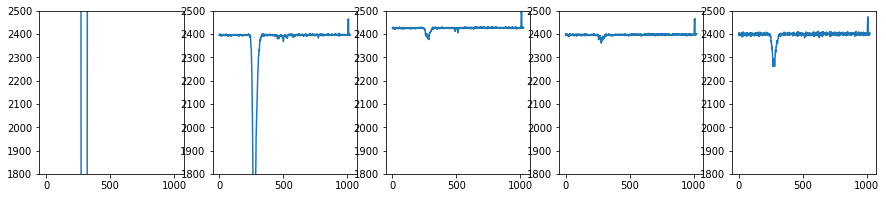

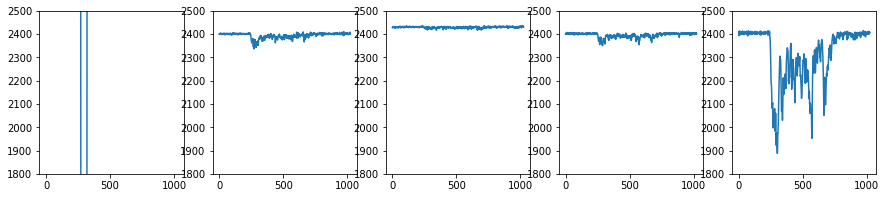

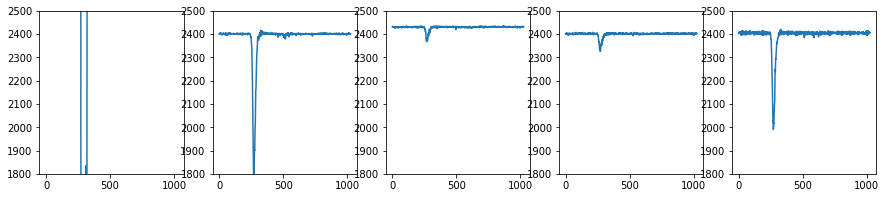

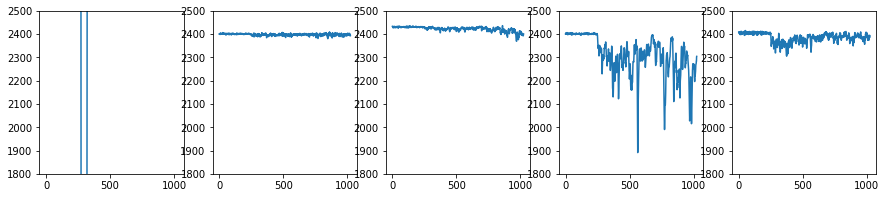

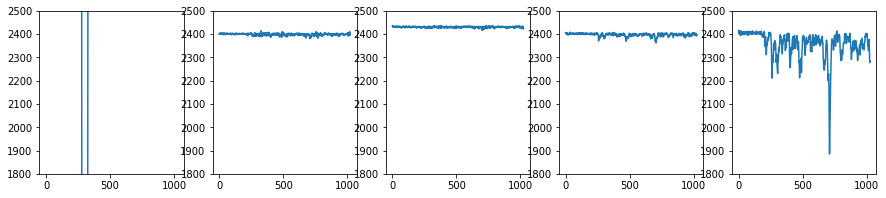

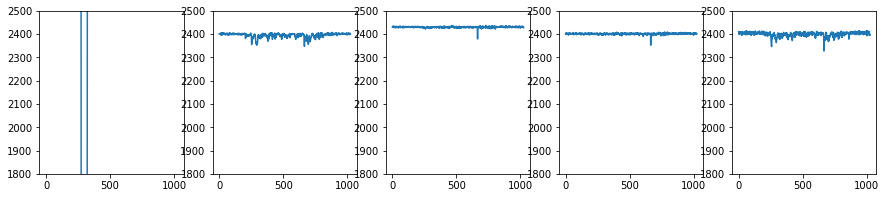

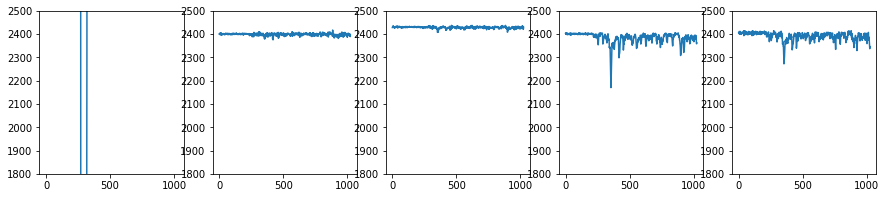

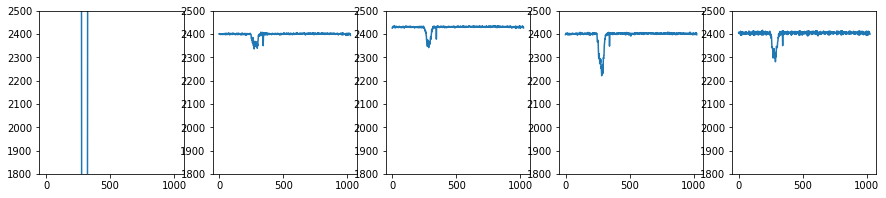

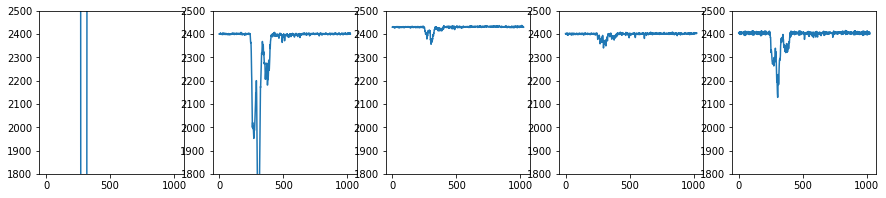

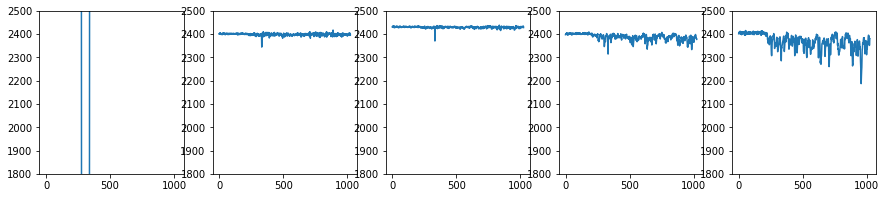

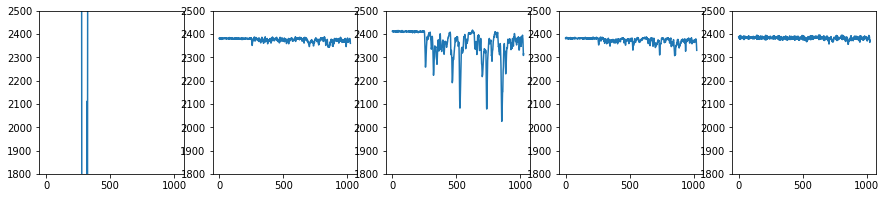

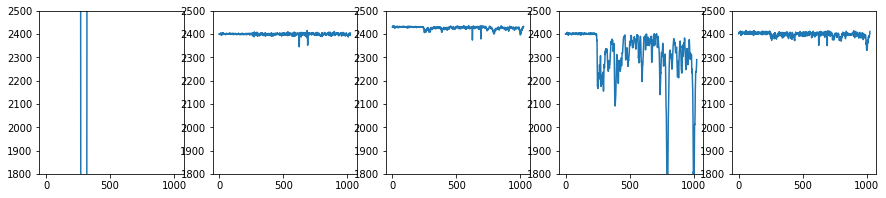

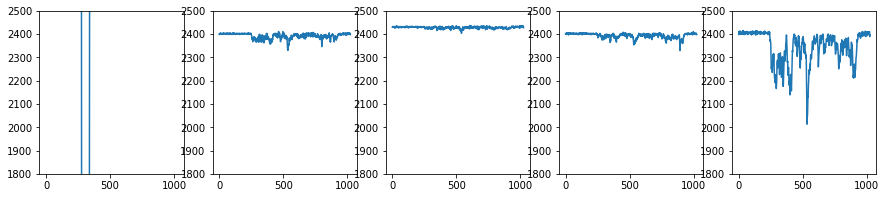

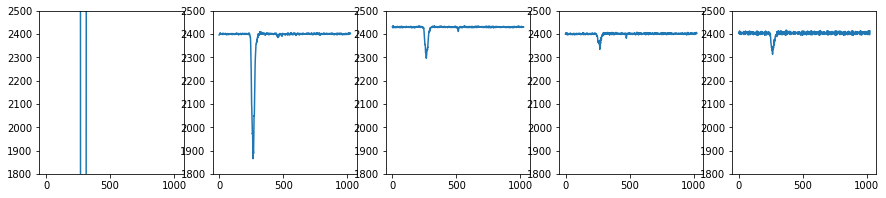

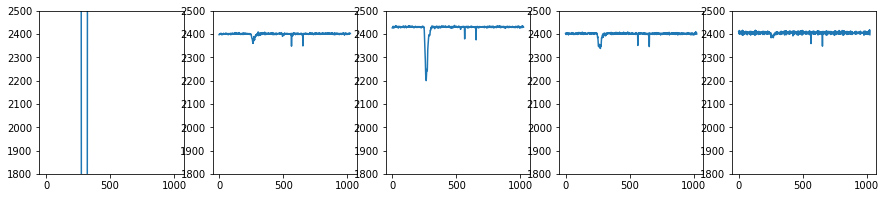

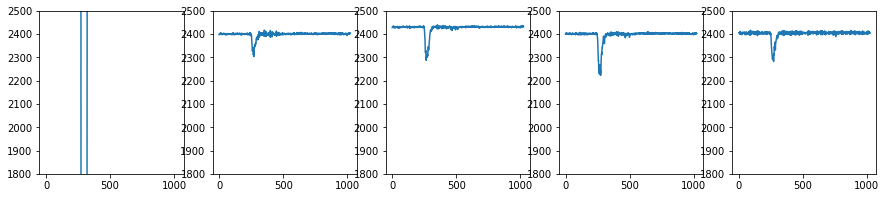

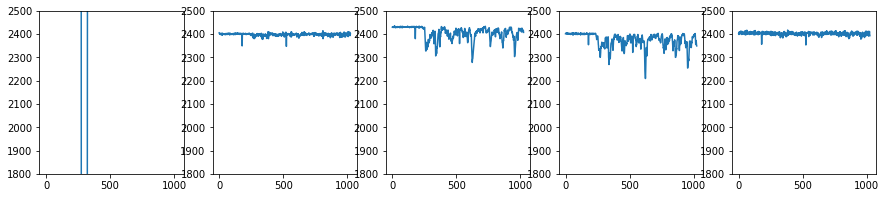

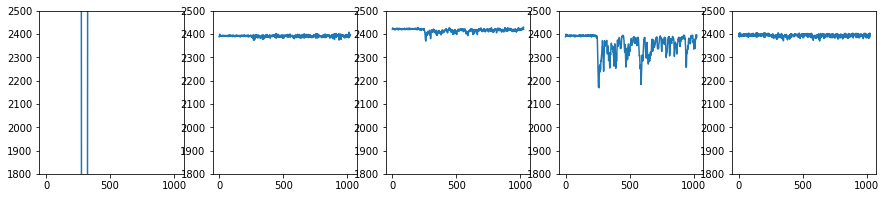

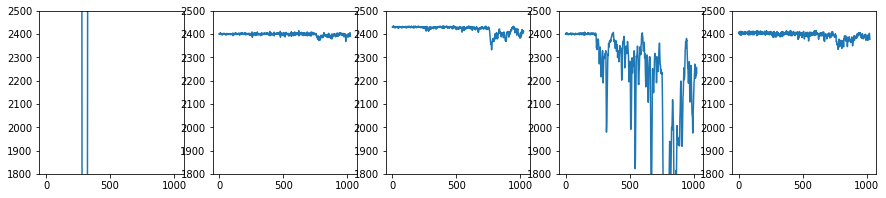

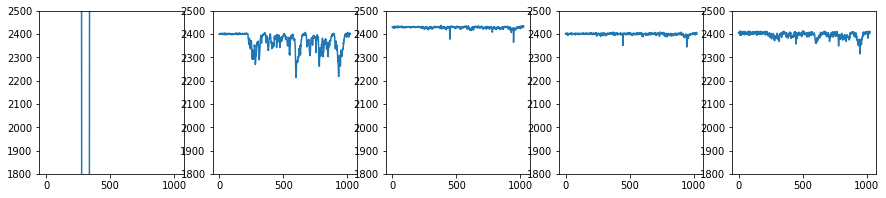

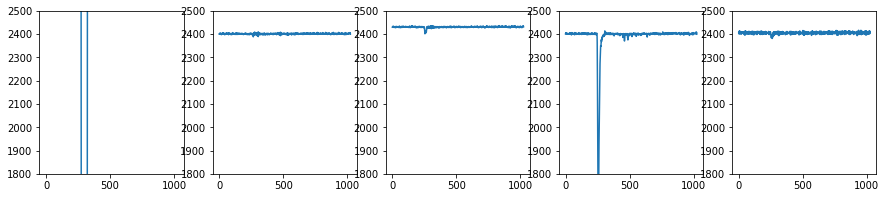

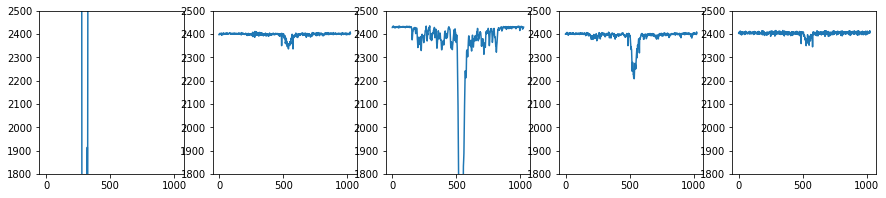

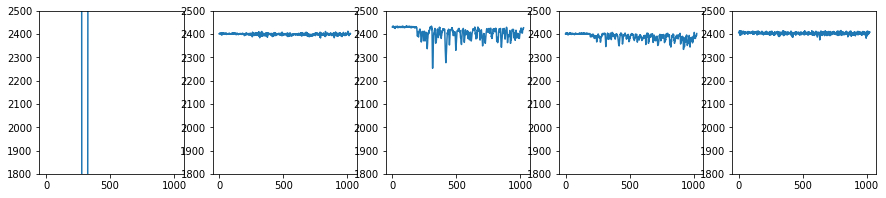

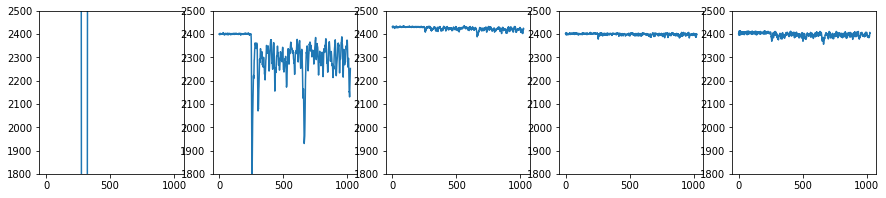

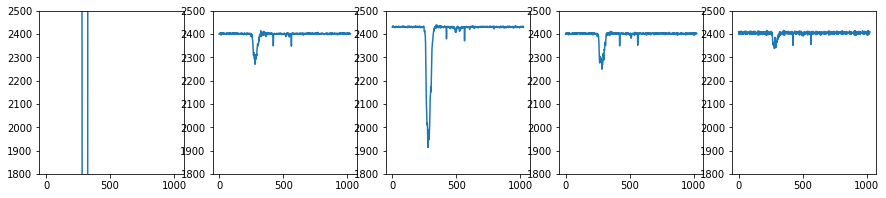

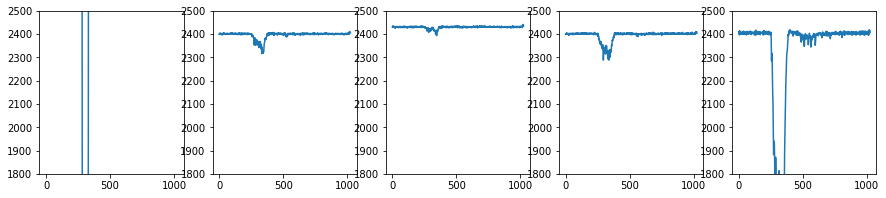

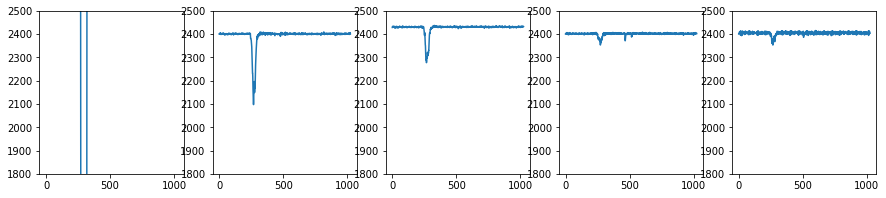

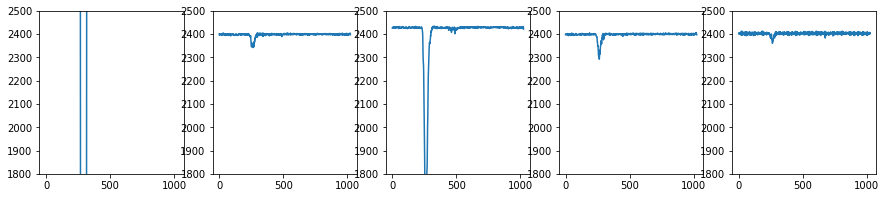

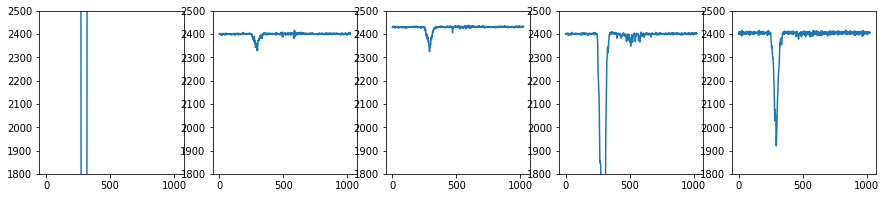

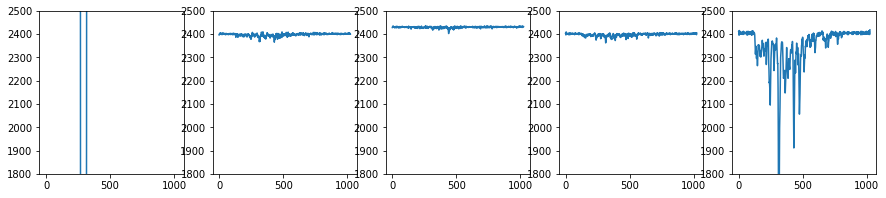

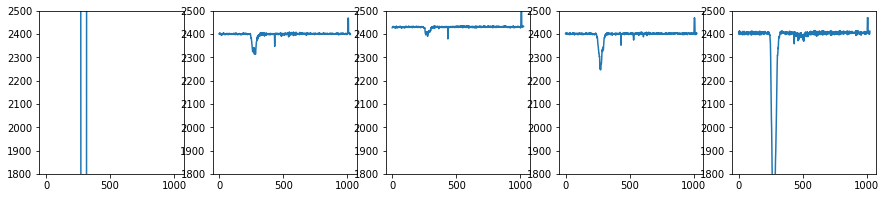

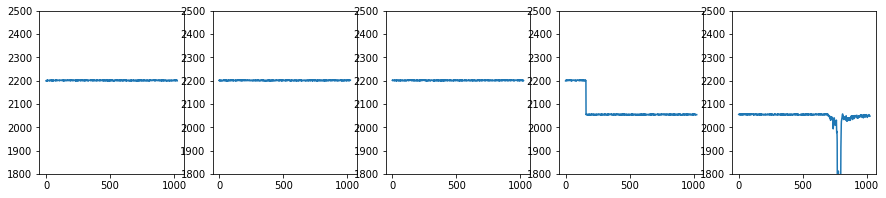

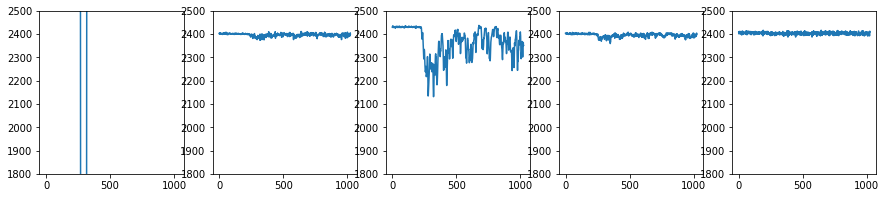

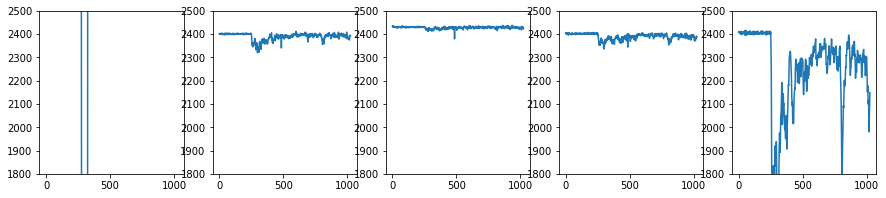

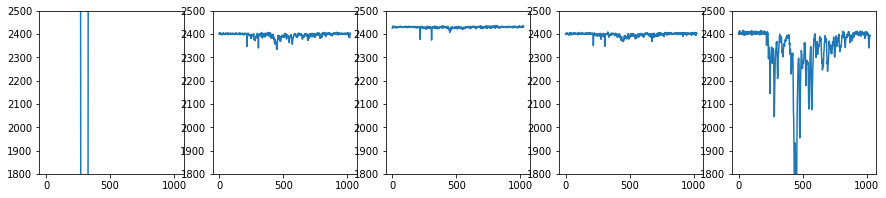

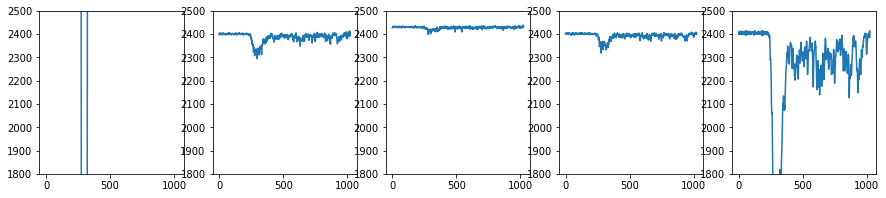

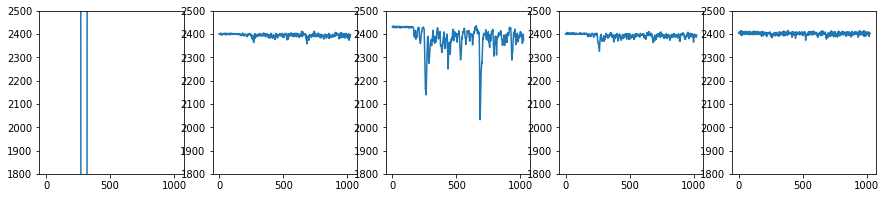

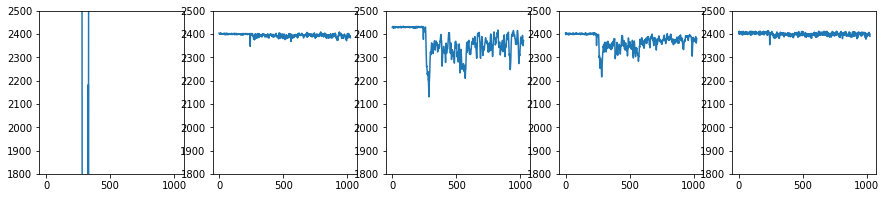

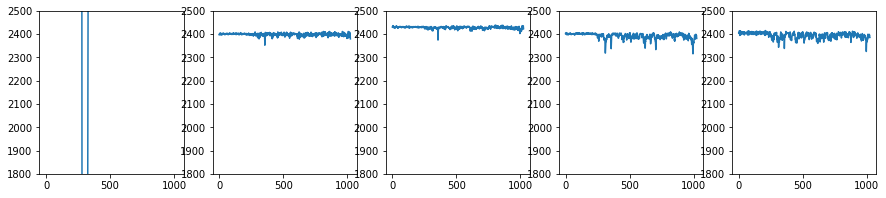

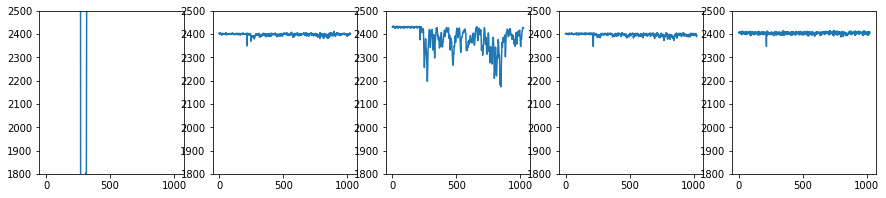

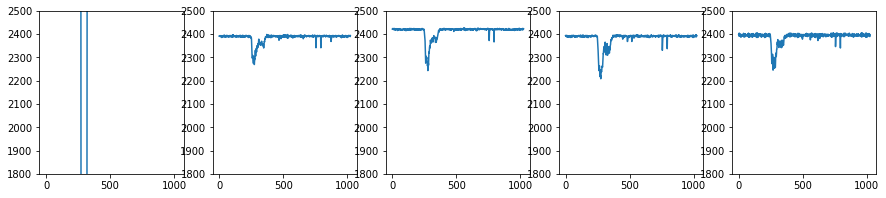

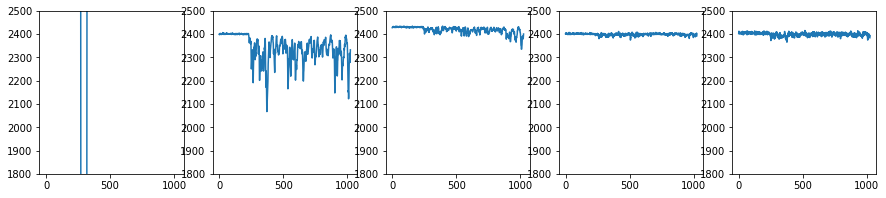

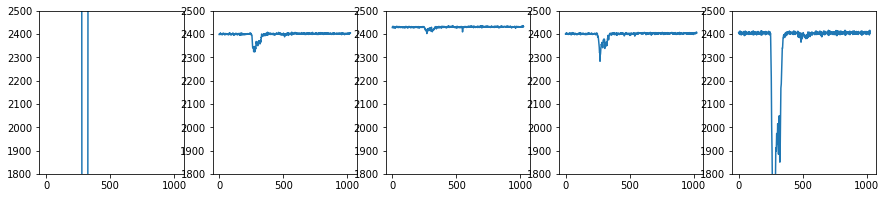

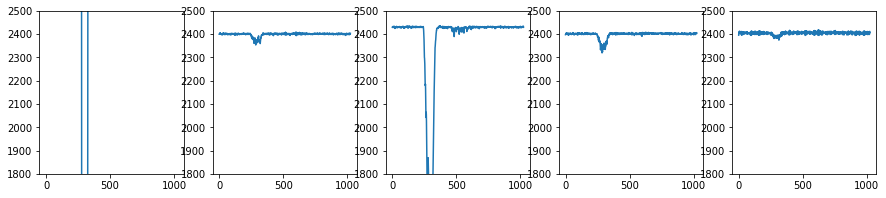

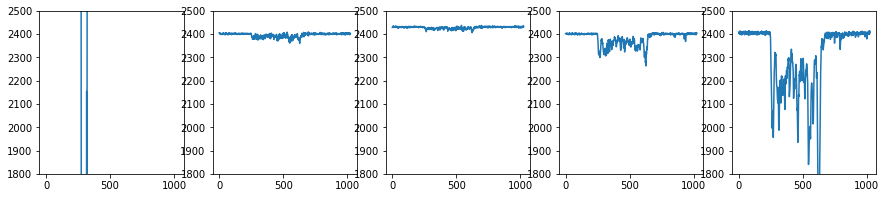

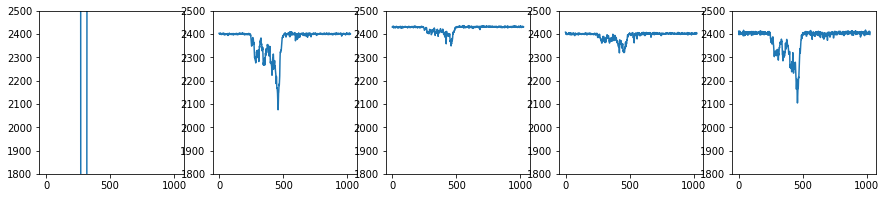

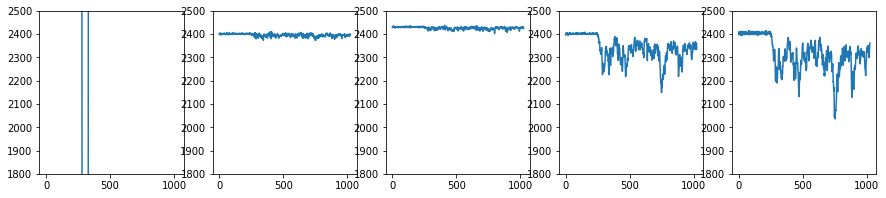

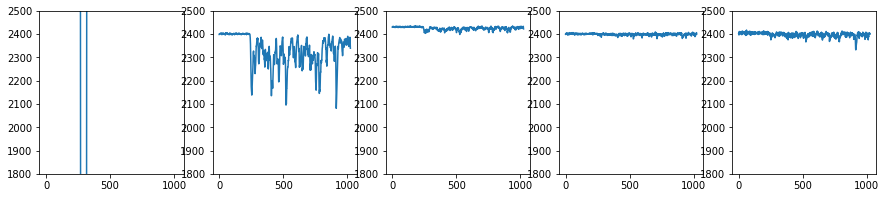

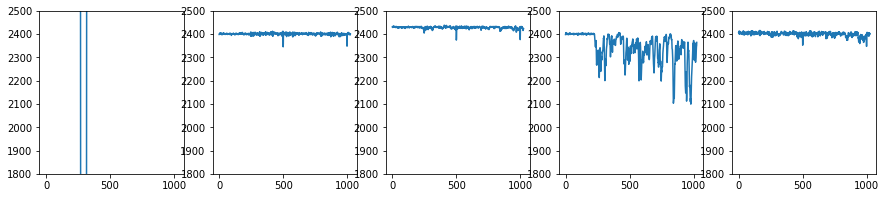

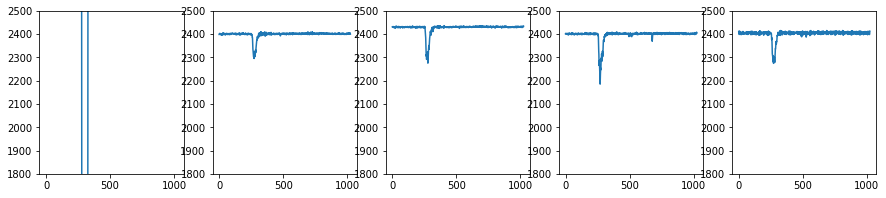

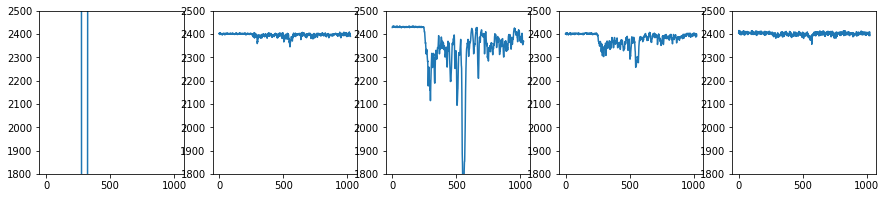

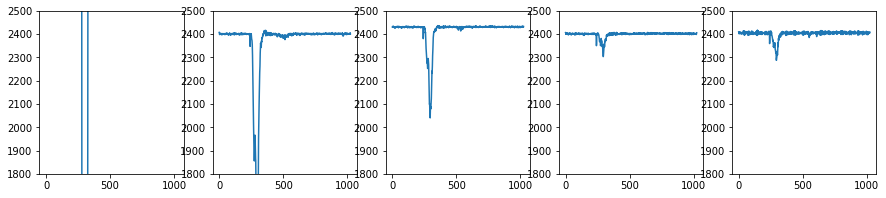

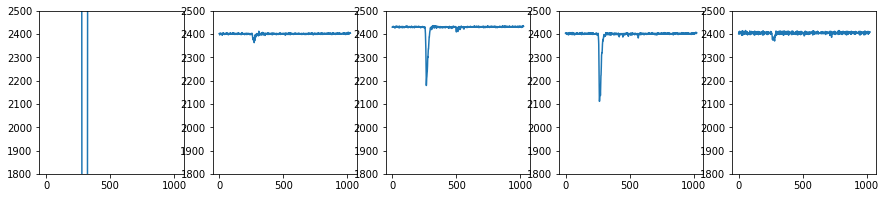

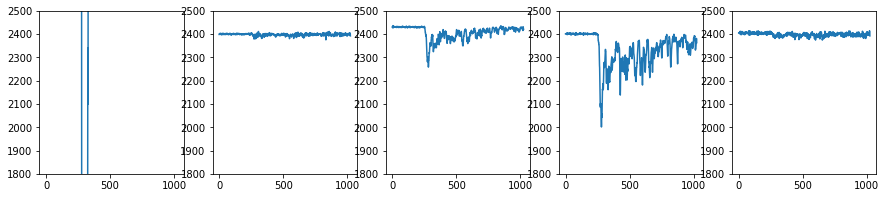

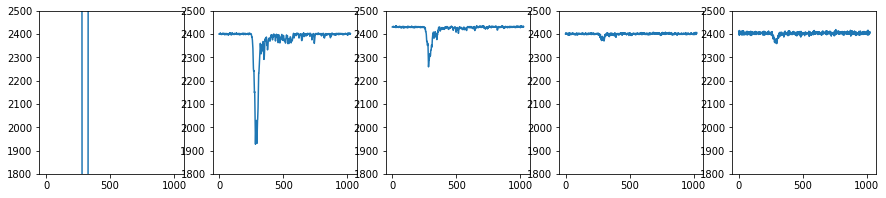

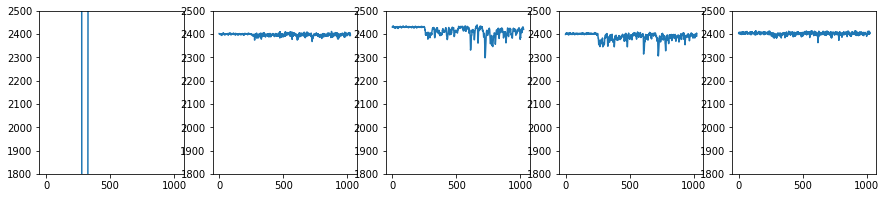

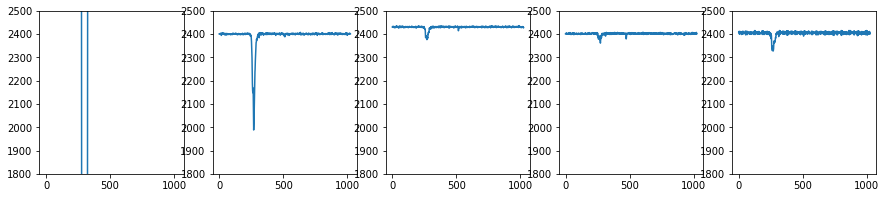

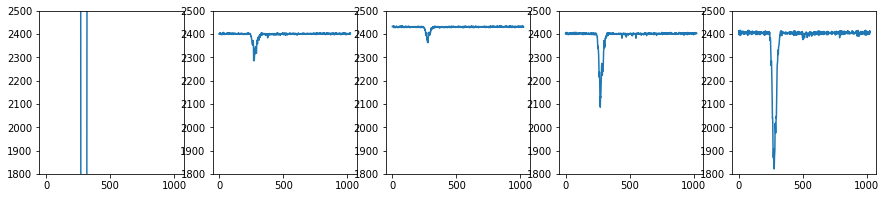

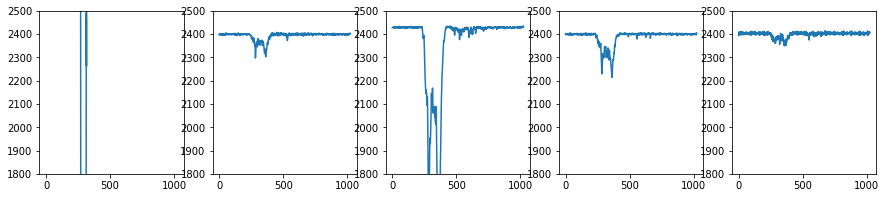

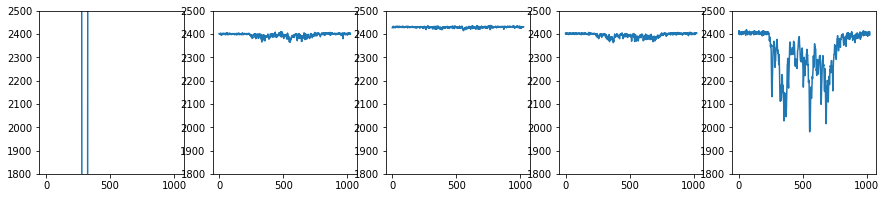

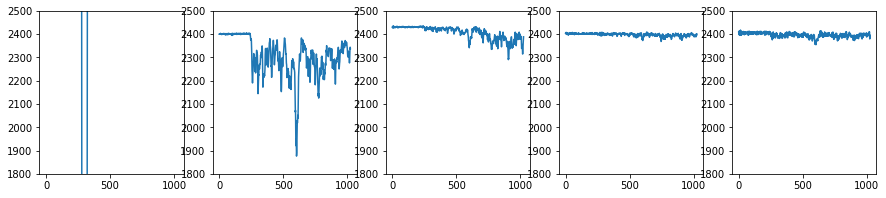

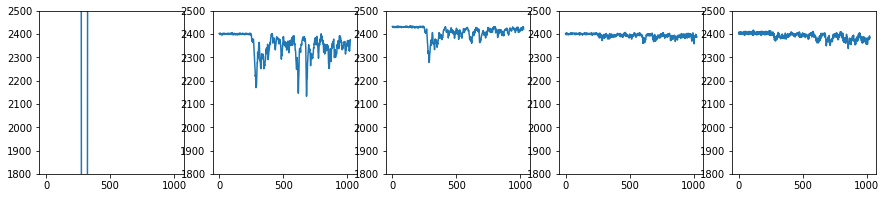

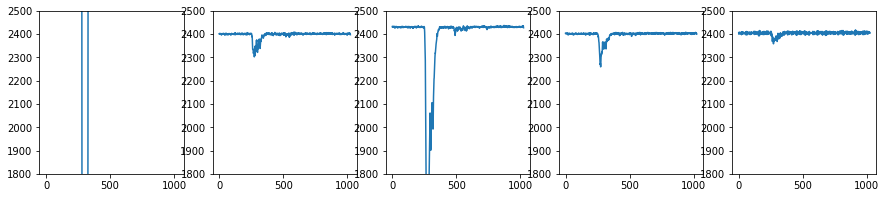

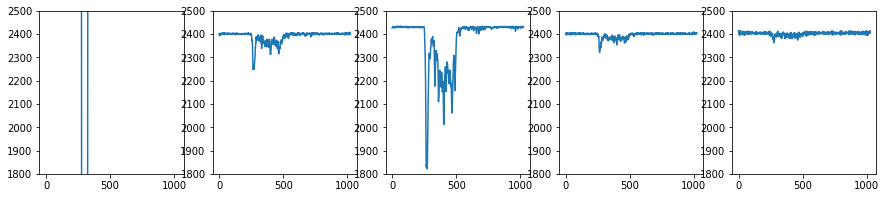

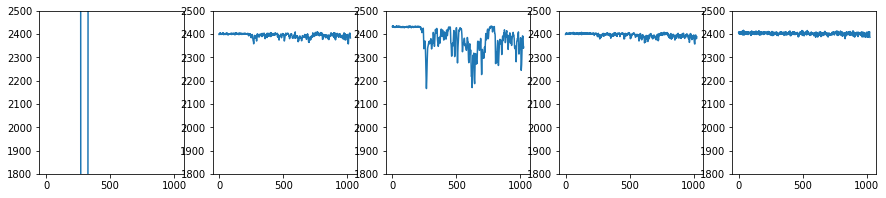

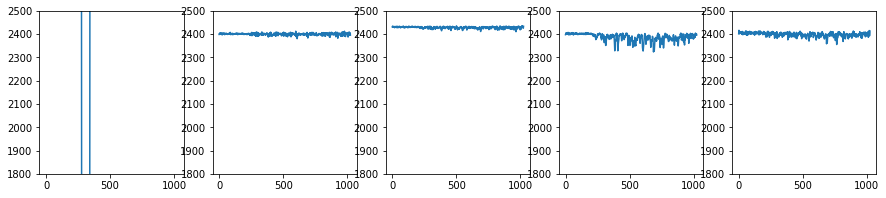

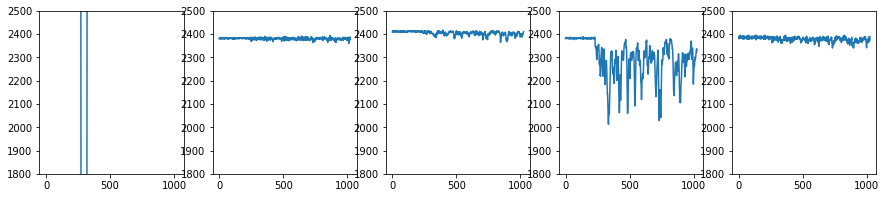

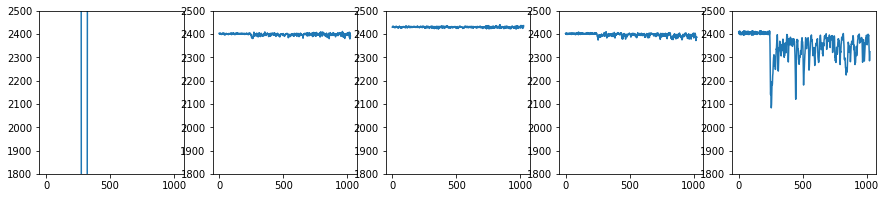

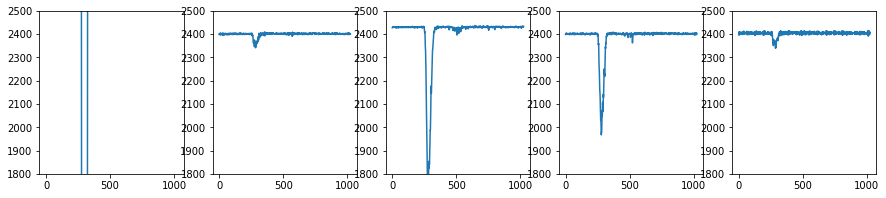

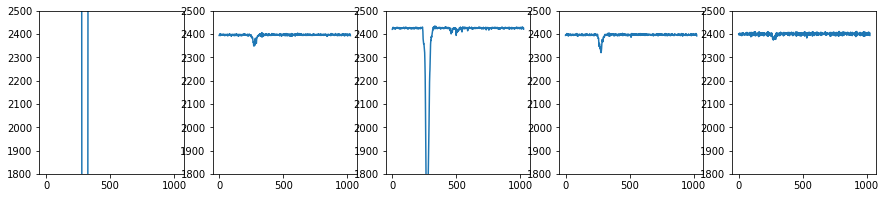

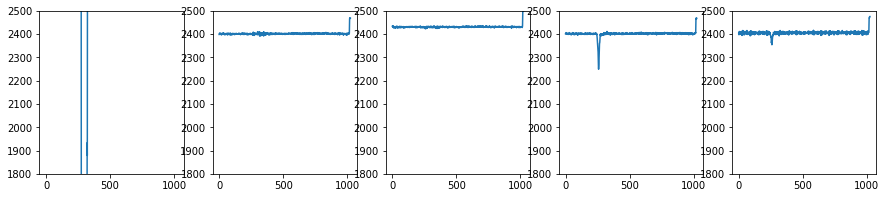

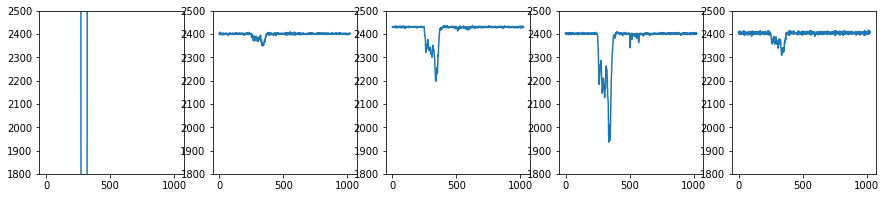

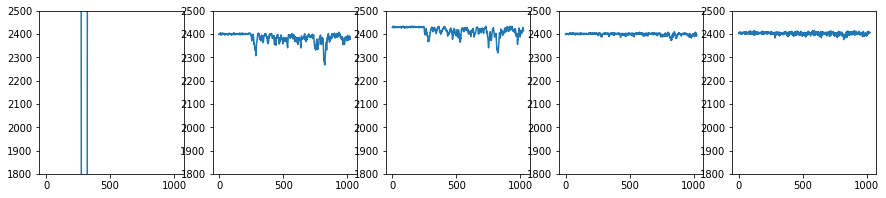

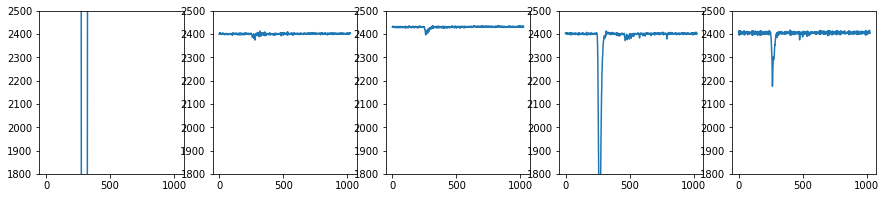

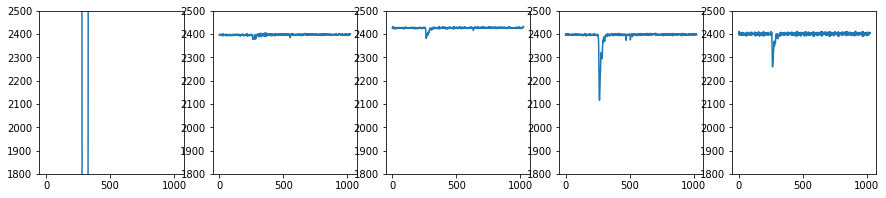

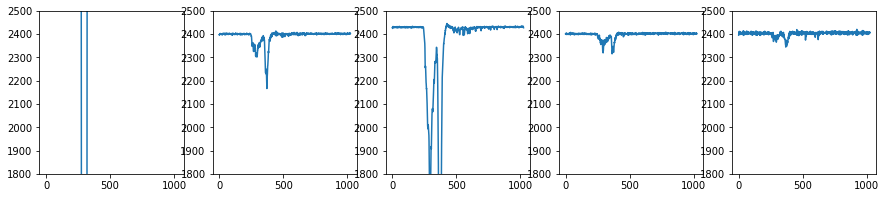

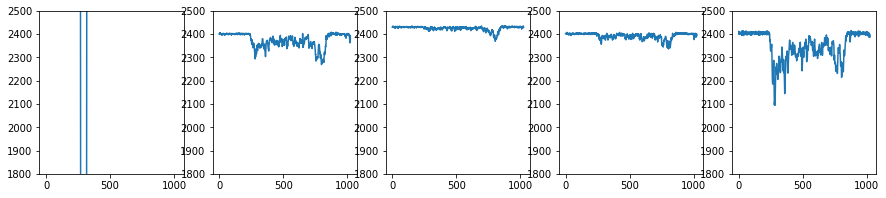

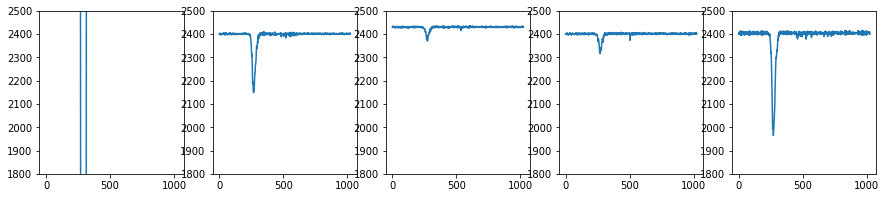

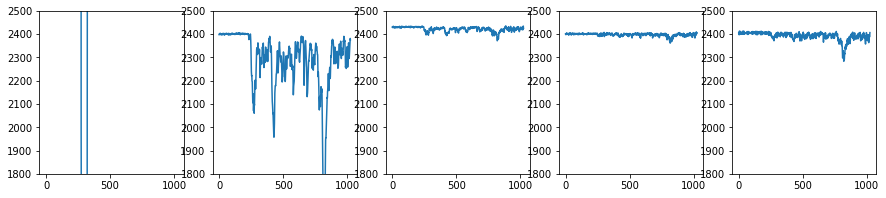

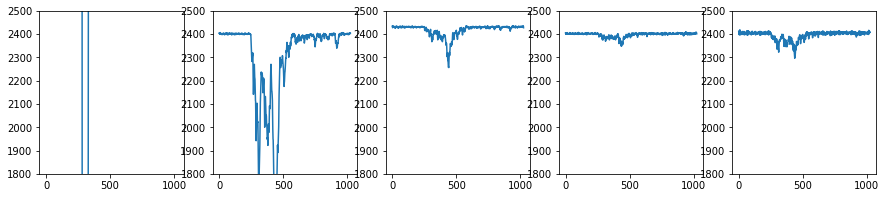

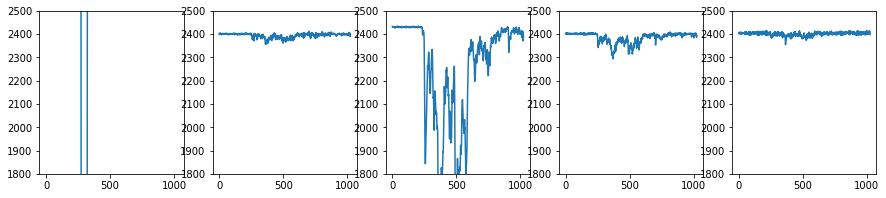

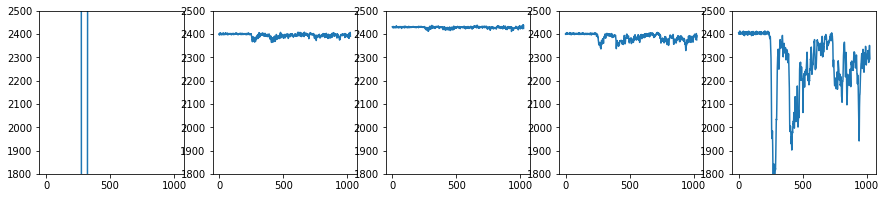

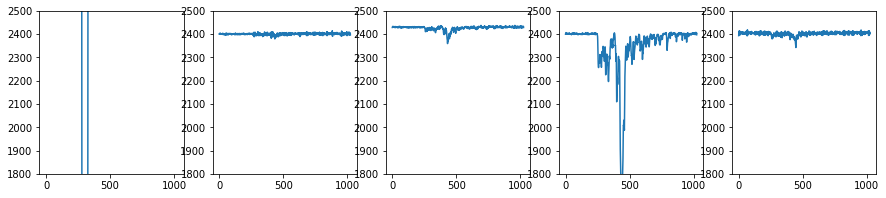

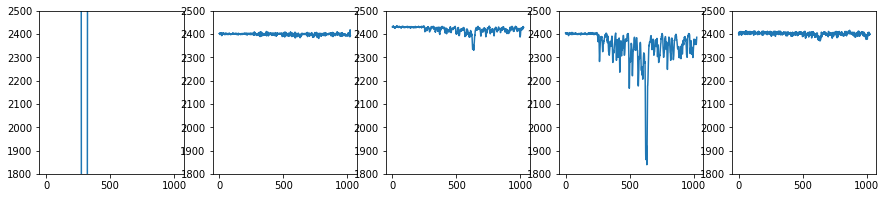

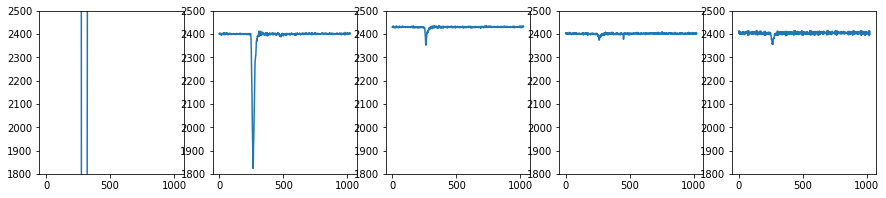

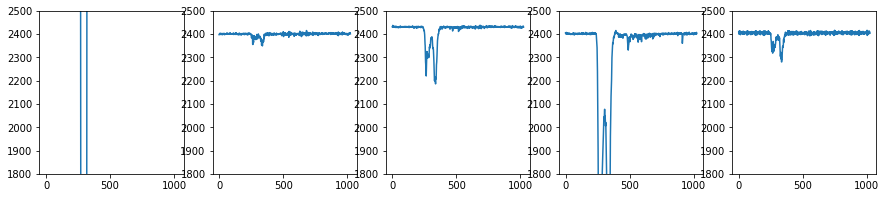

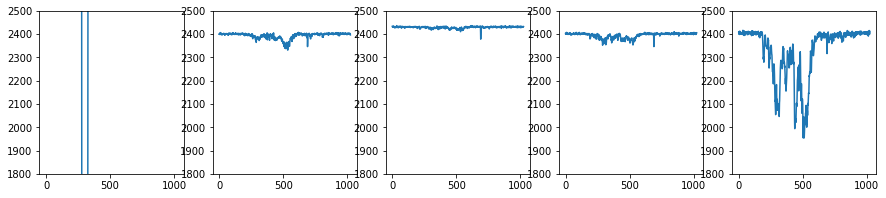

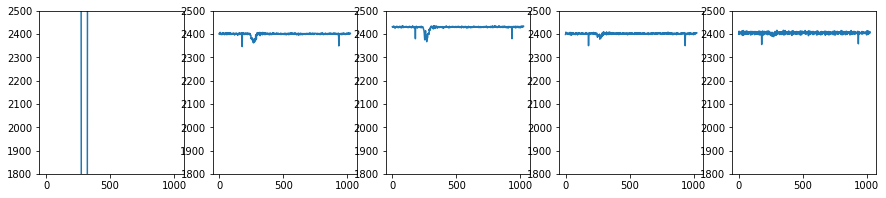

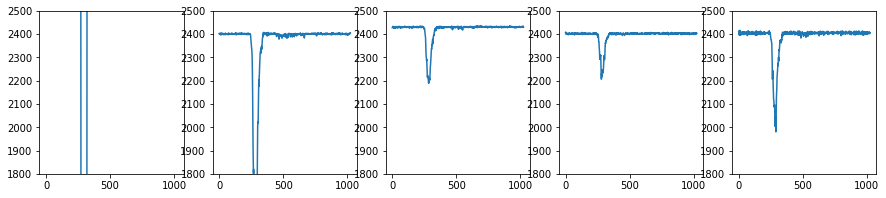

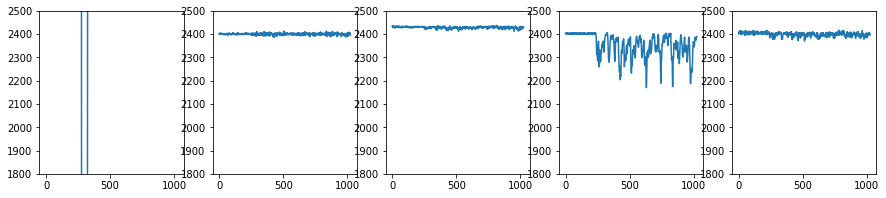

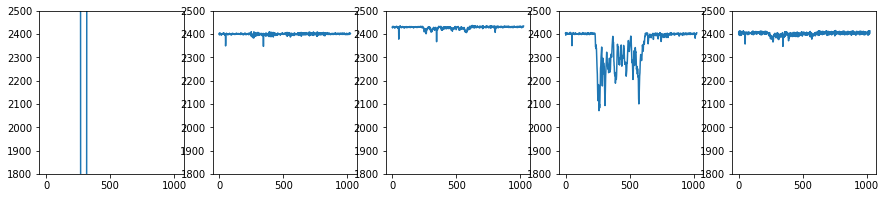

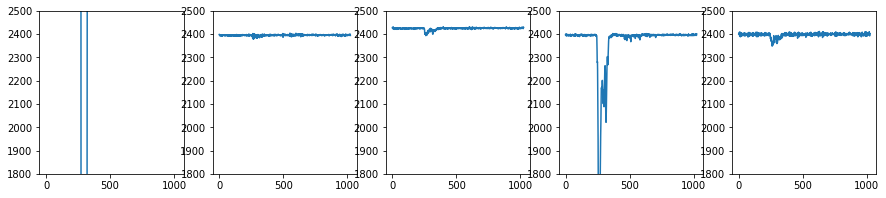

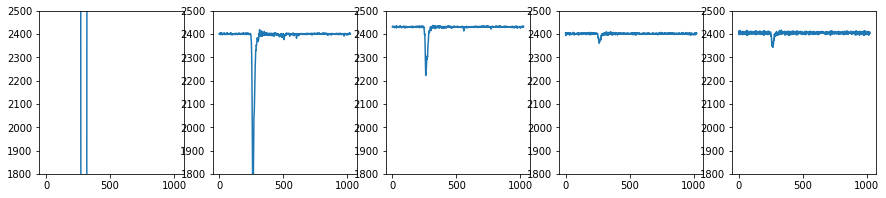

KeyboardInterrupt: 

In [147]:
mfile = cy.open_mid(run=6061, path='/s3/cygno-data/', cloud=False, tag='LNGS', verbose=False)
number_of_w_readed = 5
for event in mfile:
    if event.header.is_midas_internal_event():
        print("Saw a special event")
        continue

    bank_names = ", ".join(b.name for b in event.banks.values())
    if event.header.serial_number%1==50: 
        print("Event # %s of type ID %s contains banks %s" % (event.header.serial_number, event.header.event_id, bank_names))
        print("Received event with timestamp %s containing banks %s" % (event.header.timestamp, bank_names))
        print("%s, banks %s" % (datetime.utcfromtimestamp(event.header.timestamp).strftime('%Y-%m-%d %H:%M:%S'), bank_names))

    for bank_name, bank in event.banks.items():
        if bank_name=='DGH0': # PMTs wavform 
            header = cy.daq_dgz2header(bank)
            waveform = cy.daq_dgz2array(event.banks['DIG0'], header)
            for trigger in range(0, header[0]):
                if trigger in df[(df.cw==0) & (df.ev==event.header.serial_number)].trigger.values :
                    fig, ax = plt.subplots(1, number_of_w_readed, figsize=(15, 3))
                    for i, pmt in enumerate(cy.get_pmt_w_by_triggers(waveform, header, number_of_w_readed, trigger)):
                        ax[i].plot(np.linspace(0, len(pmt), len(pmt)), pmt)
                        ax[i].set_ylim(1800, 2500)
                    plt.show()


In [133]:
5 in df[(df.cw==2) & (df.ev==0)].trigger

True